# **Consumo de energia en la industria del acero**

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor

# =========================
# Carga y limpieza de datos
# =========================

# Carga de datos
df = pd.read_csv("steel_industry_data.csv")

# Primera visualizacion
print("Primeras 5 filas del dataframe:")
display(df.head())
print("-" * 40)
print("Informacion del dataframe:")
display(df.info())

Primeras 5 filas del dataframe:


date  Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
0  01/01/2018 00:15       3.17                                  2.95   
1  01/01/2018 00:30       4.00                                  4.46   
2  01/01/2018 00:45       3.24                                  3.28   
3  01/01/2018 01:00       3.31                                  3.56   
4  01/01/2018 01:15       3.82                                  4.50   

   Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
0                                   0.0        0.0   
1                                   0.0        0.0   
2                                   0.0        0.0   
3                                   0.0        0.0   
4                                   0.0        0.0   

   Lagging_Current_Power_Factor  Leading_Current_Power_Factor   NSM  \
0                         73.21                         100.0   900   
1                         66.77                         100.0  1800   
2                         70.28                         100.0  2700   
3                         68.09                         100.0  3600   
4                         64.72                         100.0  4500   

  WeekStatus Day_of_week   Load_Type  
0    Weekday      Monday  Light_Load  
1    Weekday      Monday  Light_Load  
2    Weekday      Monday  Light_Load  
3    Weekday      Monday  Light_Load  
4    Weekday      Monday  Light_Load

----------------------------------------
Informacion del dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type     

None

In [ ]:
# Comprobando los valores nulos del dataframe
print("Valores nulos:")
print(df.isnull().sum())
print("-" * 40)

# Comprobando los valores duplicados del dataframe
print("Valores duplicados:")
print(df.duplicated().sum())

Valores nulos:
date                                    0
Usage_kWh                               0
Lagging_Current_Reactive.Power_kVarh    0
Leading_Current_Reactive_Power_kVarh    0
CO2(tCO2)                               0
Lagging_Current_Power_Factor            0
Leading_Current_Power_Factor            0
NSM                                     0
WeekStatus                              0
Day_of_week                             0
Load_Type                               0
dtype: int64
----------------------------------------
Valores duplicados:
0


Dado que se tiene una columna para 'date' y otra para 'NSM' (nanoseconds until midnight) solo se usara una para el resto del analisis. Por lo tanto, la columna de 'NSM' no sera considerada.

In [ ]:
# ==================
# Preparado de datos
# ==================

# Transformando a formato fecha-hora
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

# Extrayendo componentes de la fecha
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute

# Borrando columnas innecesarias
df = df.drop(columns=['NSM'])

# Verficando los resultados obtenidos
print("Tipos de datos del dataframe:")
print(df.dtypes)
print("-" * 40)
print("Primeras 5 filas del dataframe preparado:")
display(df.head())

Tipos de datos del dataframe:
date                                    datetime64[ns]
Usage_kWh                                      float64
Lagging_Current_Reactive.Power_kVarh           float64
Leading_Current_Reactive_Power_kVarh           float64
CO2(tCO2)                                      float64
Lagging_Current_Power_Factor                   float64
Leading_Current_Power_Factor                   float64
WeekStatus                                      object
Day_of_week                                     object
Load_Type                                       object
month                                            int32
day                                              int32
hour                                             int32
minute                                           int32
dtype: object
----------------------------------------
Primeras 5 filas del dataframe preparado:


date  Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
0 2018-01-01 00:15:00       3.17                                  2.95   
1 2018-01-01 00:30:00       4.00                                  4.46   
2 2018-01-01 00:45:00       3.24                                  3.28   
3 2018-01-01 01:00:00       3.31                                  3.56   
4 2018-01-01 01:15:00       3.82                                  4.50   

   Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
0                                   0.0        0.0   
1                                   0.0        0.0   
2                                   0.0        0.0   
3                                   0.0        0.0   
4                                   0.0        0.0   

   Lagging_Current_Power_Factor  Leading_Current_Power_Factor WeekStatus  \
0                         73.21                         100.0    Weekday   
1                         66.77                         100.0    Weekday   
2                         70.28                         100.0    Weekday   
3                         68.09                         100.0    Weekday   
4                         64.72                         100.0    Weekday   

  Day_of_week   Load_Type  month  day  hour  minute  
0      Monday  Light_Load      1    1     0      15  
1      Monday  Light_Load      1    1     0      30  
2      Monday  Light_Load      1    1     0      45  
3      Monday  Light_Load      1    1     1       0  
4      Monday  Light_Load      1    1     1      15

In [ ]:
# ===================================
# Analsis exploratorio de datos (EDA)
# ===================================

# ===================
# Analisis categorico
# ===================

# Primer conteo para las variables categoricas
cat_cols_EDA = ['WeekStatus', 'Day_of_week', 'Load_Type']

# Oden para los dias en 'Day_of_week'
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for col in cat_cols_EDA:
    print(df[col].value_counts())
    print("-" * 30)

WeekStatus
Weekday    25056
Weekend     9984
Name: count, dtype: int64
------------------------------
Day_of_week
Monday       5088
Tuesday      4992
Wednesday    4992
Thursday     4992
Friday       4992
Saturday     4992
Sunday       4992
Name: count, dtype: int64
------------------------------
Load_Type
Light_Load      18072
Medium_Load      9696
Maximum_Load     7272
Name: count, dtype: int64
------------------------------


/tmp/ipython-input-407-1662305768.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="pastel")
/tmp/ipython-input-407-1662305768.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="pastel")
/tmp/ipython-input-407-1662305768.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="pastel")


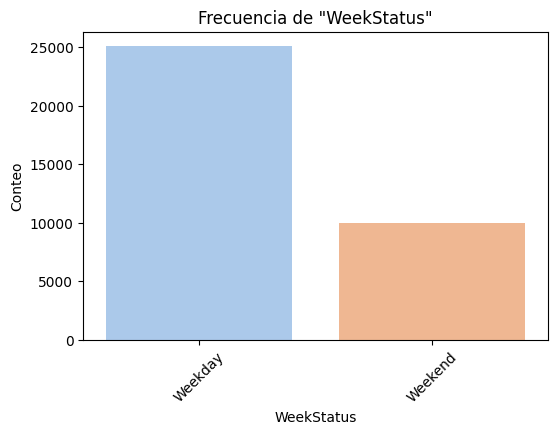

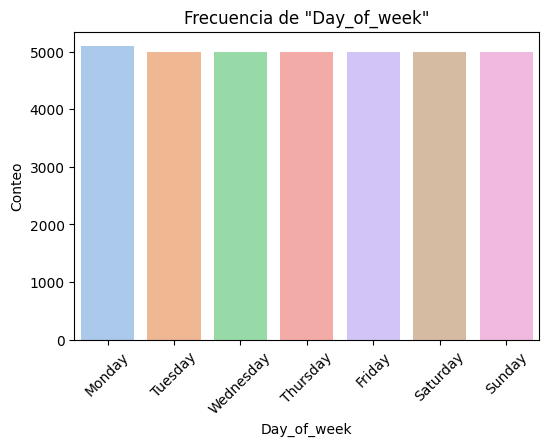

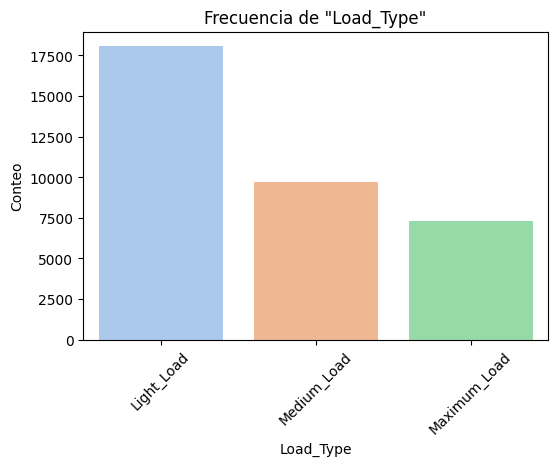

In [ ]:
# Visualizacion para las variables categoricas

for col in cat_cols_EDA:
    plt.figure(figsize=(6, 4))
    plt.xticks(rotation=45)
    sns.countplot(data=df, x=col, palette="pastel")
    plt.title(f'Frecuencia de "{col}"')
    plt.ylabel('Conteo')

Los valores obtenidos para 'WeekStatus' tienen sentido logico, ya que 2 dias de las semana son Weekend y 5 dias de la semana van para Weekday. La visualizacion de 'Load_Type' presenta que la mayoria del tiempo, la planta trabaja con carga pequeñas. Para 'Day_of_week' los valores presentados tambien tienen sentido. Sin emabargo, el dia Monday tiene un mayor conteo que el resto de dias, lo que podria significar algun error en los datos.

In [ ]:
# Verificacion de un posible error en el data set

counter = 0
for day in df['Day_of_week']:
    if day == 'Monday':
        counter += 1
    else:
        break

print('Datos tomados por dia:', counter)

Datos tomados por dia: 96


Con la anterior seccion realizada, se puede asumir que cada dia tiene 96 datos tomados. Por lo tanto, la diferencia anterior mostrada con mas valores en 'Monday' puede darse debido a que el dataset tomo un dia extra de datos. Por lo tanto, no se justifica la presencia de errores en el dataset. Ademas, los valores extra para 'Monday' son pequeños en comparacion al resto del dataset, por lo tanto no se los eliminara para el posterior analisis y modelo.

CO2(tCO2)
0.00    20990
0.02     4643
0.03     4261
0.04     1834
0.01     1512
0.05     1363
0.06      410
0.07       27
Name: count, dtype: int64


/tmp/ipython-input-409-4268556489.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='CO2(tCO2)', palette="pastel")


Text(0, 0.5, 'Conteo')

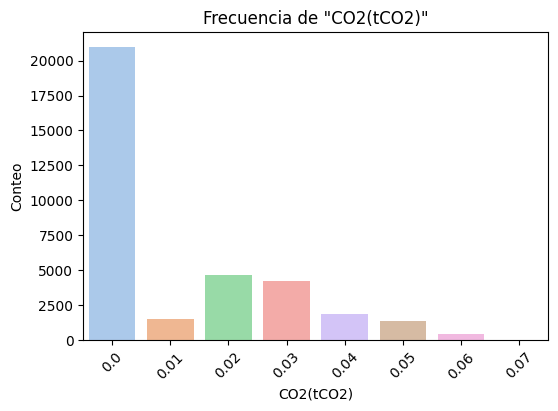

In [ ]:
# ============================================
# Analisis univariado para variables discretas
# ============================================

# Conteo de la variable 'CO2(tCO2)'
print(df['CO2(tCO2)'].value_counts())

# Visualizacion de la variable discreta
plt.figure(figsize=(6, 4))
plt.xticks(rotation=45)
sns.countplot(data=df, x='CO2(tCO2)', palette="pastel")
plt.title(f'Frecuencia de "CO2(tCO2)"')
plt.ylabel('Conteo')

La distribucion tiene una tendencia mayor con la cola izquierda, esto dado a que la mayoria del tiempo la planta no esta en funcionamiento maximo. Por lo tanto, esta no produce nada de CO2 durante estos periodos.

In [ ]:
# ================================
# Analisis univariado cuantitativo
# ================================

# Primera visualizacion de los datos en general
display(df.describe())

date     Usage_kWh  \
count                35040  35040.000000   
mean   2018-07-02 11:52:30     27.386892   
min    2018-01-01 00:00:00      0.000000   
25%    2018-04-02 05:56:15      3.200000   
50%    2018-07-02 11:52:30      4.570000   
75%    2018-10-01 17:48:45     51.237500   
max    2018-12-31 23:45:00    157.180000   
std                    NaN     33.444380   

       Lagging_Current_Reactive.Power_kVarh  \
count                          35040.000000   
mean                              13.035384   
min                                0.000000   
25%                                2.300000   
50%                                5.000000   
75%                               22.640000   
max                               96.910000   
std                               16.306000   

       Leading_Current_Reactive_Power_kVarh     CO2(tCO2)  \
count                          35040.000000  35040.000000   
mean                               3.870949      0.011524   
min                                0.000000      0.000000   
25%                                0.000000      0.000000   
50%                                0.000000      0.000000   
75%                                2.090000      0.020000   
max                               27.760000      0.070000   
std                                7.424463      0.016151   

       Lagging_Current_Power_Factor  Leading_Current_Power_Factor  \
count                  35040.000000                  35040.000000   
mean                      80.578056                     84.367870   
min                        0.000000                      0.000000   
25%                       63.320000                     99.700000   
50%                       87.960000                    100.000000   
75%                       99.022500                    100.000000   
max                      100.000000                    100.000000   
std                       18.921322                     30.456535   

              month           day          hour        minute  
count  35040.000000  35040.000000  35040.000000  35040.000000  
mean       6.526027     15.720548     11.500000     22.500000  
min        1.000000      1.000000      0.000000      0.000000  
25%        4.000000      8.000000      5.750000     11.250000  
50%        7.000000     16.000000     11.500000     22.500000  
75%       10.000000     23.000000     17.250000     33.750000  
max       12.000000     31.000000     23.000000     45.000000  
std        3.447901      8.796373      6.922285     16.770749

/tmp/ipython-input-411-3357303495.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=col, kde=True, bins=50, palette="pastel")


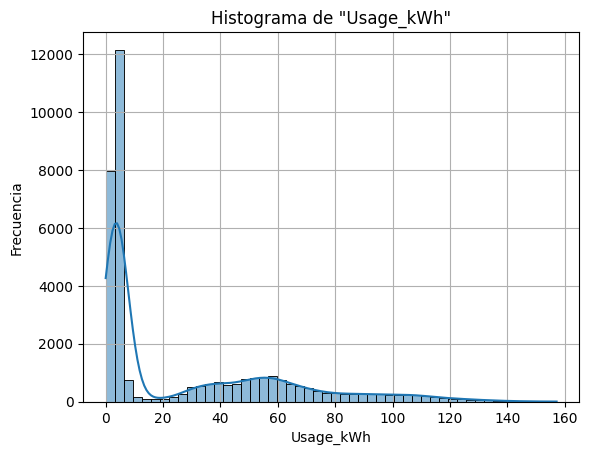

/tmp/ipython-input-411-3357303495.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=col, kde=True, bins=50, palette="pastel")


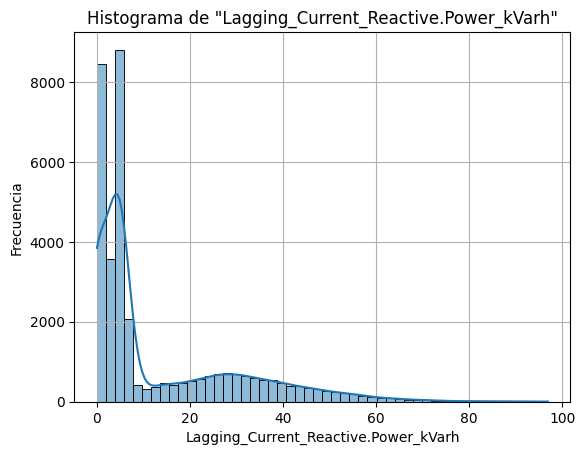

/tmp/ipython-input-411-3357303495.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=col, kde=True, bins=50, palette="pastel")


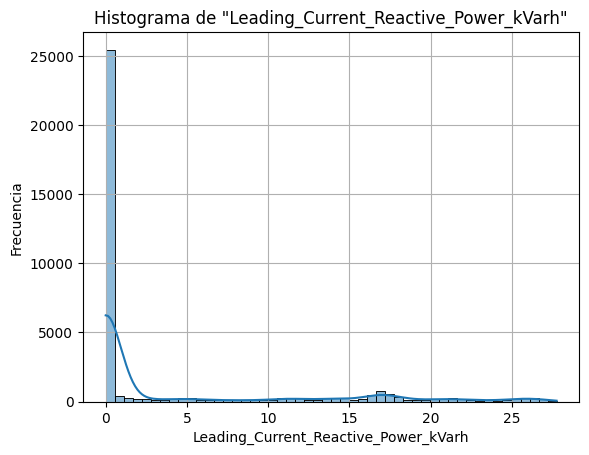

/tmp/ipython-input-411-3357303495.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=col, kde=True, bins=50, palette="pastel")


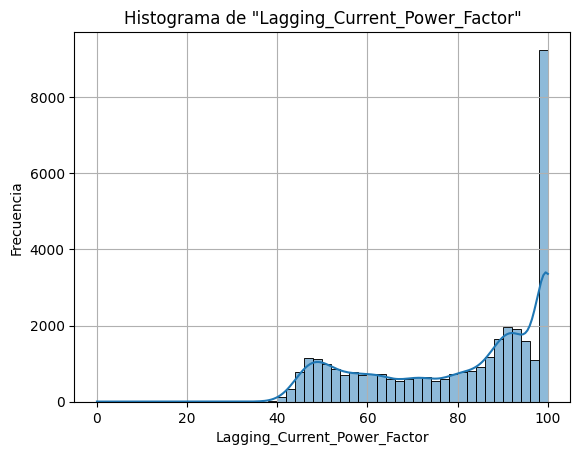

/tmp/ipython-input-411-3357303495.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=col, kde=True, bins=50, palette="pastel")


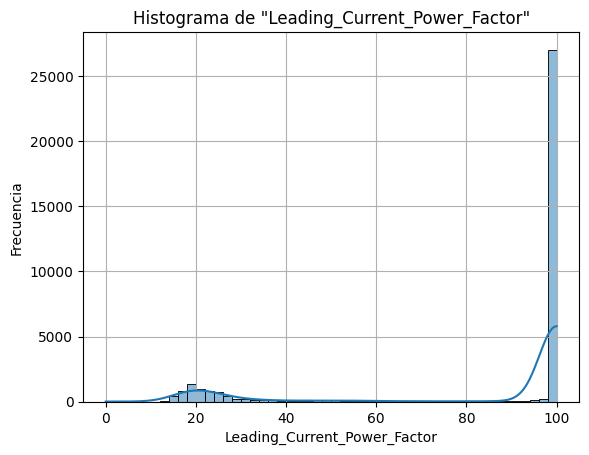

In [ ]:
# Filtrando solo columnas numericas
numericas = df[['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
                'Leading_Current_Reactive_Power_kVarh',
                'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor']]

# Bucle para graficar
for col in numericas:
    sns.histplot(data=df, x=col, kde=True, bins=50, palette="pastel")
    plt.title(f'Histograma de "{col}"')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.grid()
    plt.show()

Es importante notar que la mayoria de los valores de 'Usage_KWh' son bajos, sin embargo no son 0. Igualmente para 'Lagging_Current_Reactive.Power_kVarh' y 'Lagging_Current_Power_Factor' presentan una tendencia mayor en la cola izquierda, por ello se realizara una transformacion logaritmica para ambos casos (y asi obtener una mejor visualizacion).
Para los valores de 'Leading_Current_Reactive_Power_kVarh' y en consecuencia 'Leading_Current_Power_Factor' se nota una fuerte frecuencia en 0, por lo tanto una posible aproximacion seria volver de estas variables discretas, donde los valores estaran dados por 0 o algun valor mayor a 0.
Igualmente, los graficos para los factores de potencia son redondantes para el analisis, ya que dependen de 'Lagging_Current_Reactive.Power_kVarh' y 'Leading_Current_Reactive_Power_kVarh', por lo tanto no se los considerara para el analisis posterior.

Leading_Current_Reactive_Power_kVarh_Bin
0    23610
1    11430
Name: count, dtype: int64


/tmp/ipython-input-412-441223093.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Leading_Current_Reactive_Power_kVarh_Bin', palette="pastel")


Text(0, 0.5, 'Conteo')

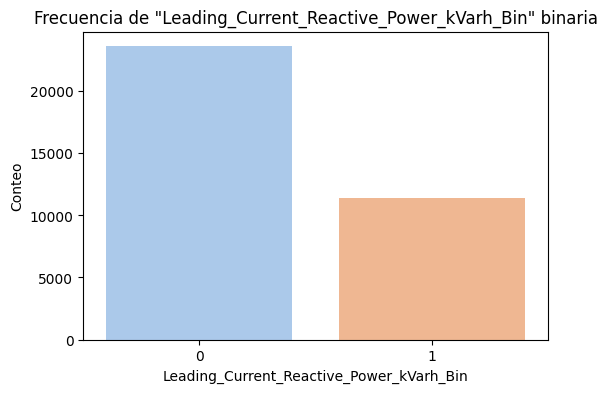

In [ ]:
# Tranformando 'Leading_Current_Reactive_Power_kVarhr' a datos binarios
df['Leading_Current_Reactive_Power_kVarh_Bin'] = (df['Leading_Current_Reactive_Power_kVarh'] > 0).astype(int)

# Conteo de la variable 'Leading_Current_Reactive_Power_kVarh'
print(df['Leading_Current_Reactive_Power_kVarh_Bin'].value_counts())

# Visualizacion de la variable discreta
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Leading_Current_Reactive_Power_kVarh_Bin', palette="pastel")
plt.title(f'Frecuencia de "Leading_Current_Reactive_Power_kVarh_Bin" binaria')
plt.ylabel('Conteo')

/tmp/ipython-input-413-1550168195.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=col, kde=True, bins=50, palette="pastel")


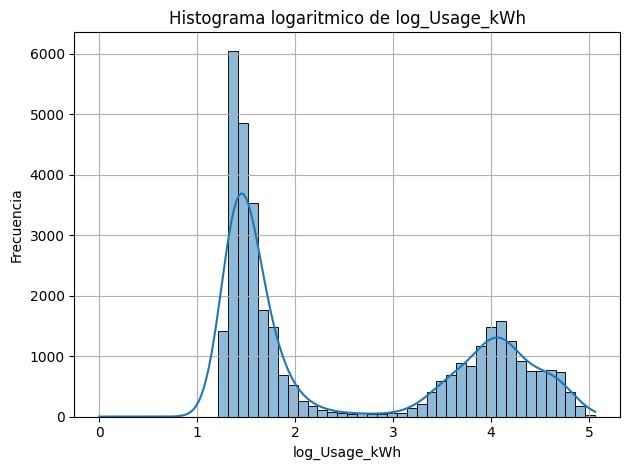

/tmp/ipython-input-413-1550168195.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=col, kde=True, bins=50, palette="pastel")


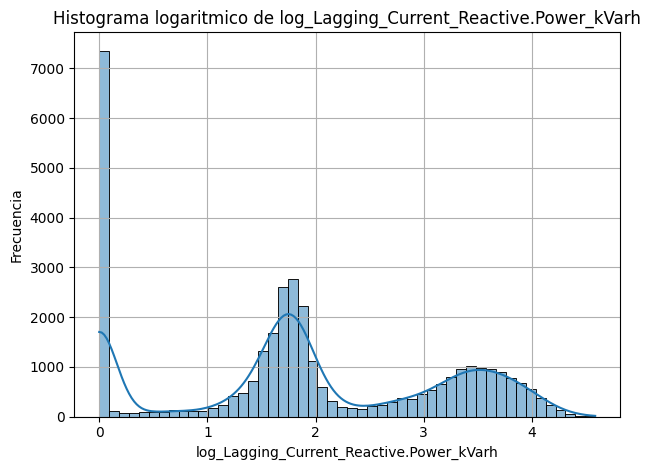

In [ ]:
# Creando un dataframe logartimizado
numerics_log = df[['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh']]

for col in numerics_log:
    df[f'log_{col}'] = np.log1p(df[col])

log_cols = [col for col in df.columns if col.startswith('log_')]

# Graficando cada histograma
for col in log_cols:
    sns.histplot(data=df, x=col, kde=True, bins=50, palette="pastel")
    plt.title(f'Histograma logaritmico de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Ambos casos presentan graficas bimodales, lo cual ayuda a la eleccion posterior del modelo de machine learning.

/tmp/ipython-input-414-2290178175.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, y=col, palette="pastel")


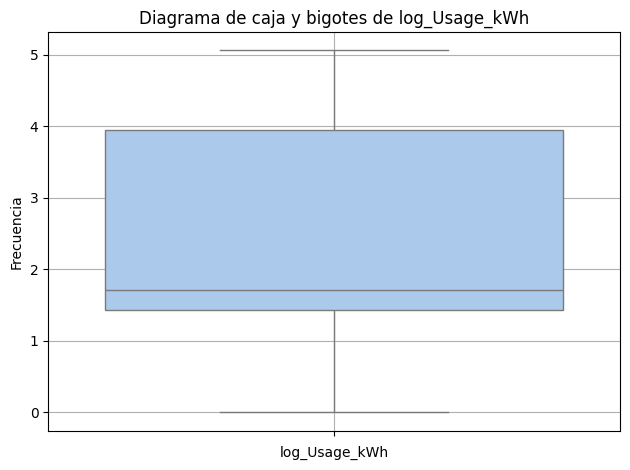

/tmp/ipython-input-414-2290178175.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, y=col, palette="pastel")


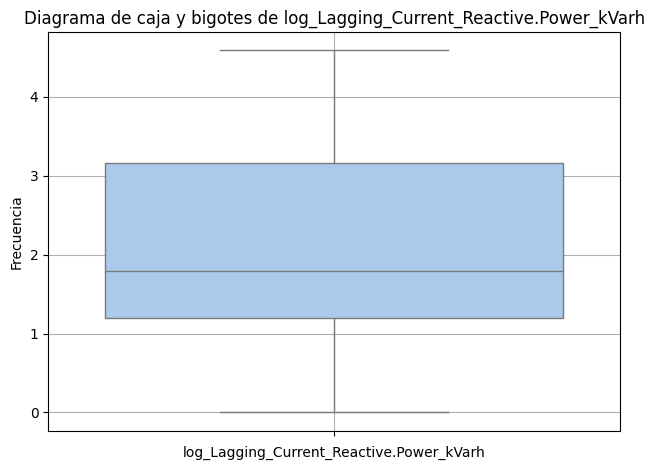

In [ ]:
# Realizando diagramam de caja y bigotes para ambas variables

for col in log_cols:
    sns.boxplot(data=df, y=col, palette="pastel")
    plt.title(f'Diagrama de caja y bigotes de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Ambos boxplots no presentan outliers, por lo tanto se puede seguir al analisis por agrupracion de variables categoricas y discretas

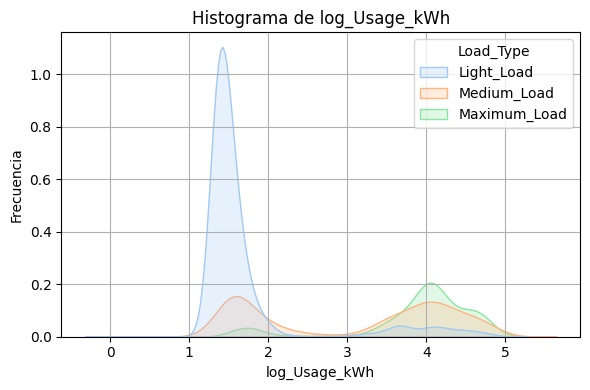

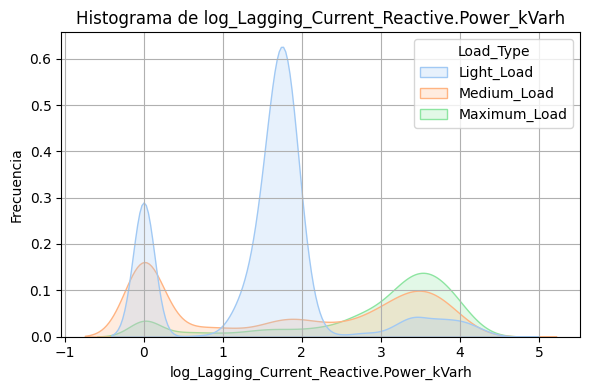

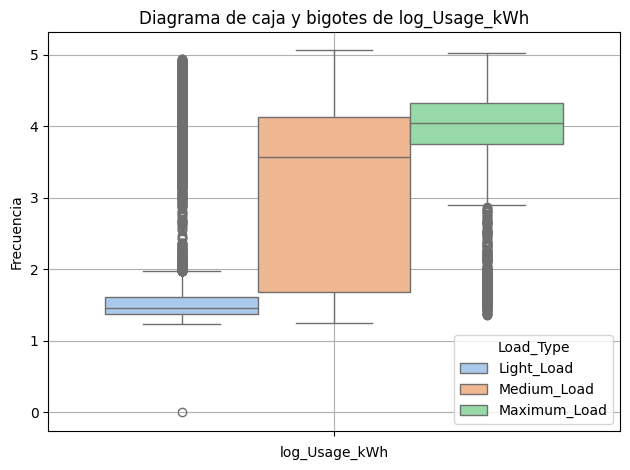

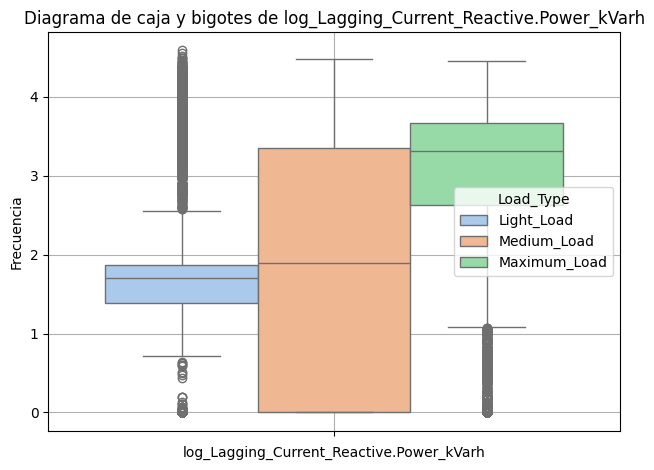

In [ ]:
# Agrupacion con 'Load_Type'

for col in log_cols:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df, x=col, hue='Load_Type', fill=True, palette="pastel")
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for col in log_cols:
    sns.boxplot(data=df, y=col, hue='Load_Type', palette="pastel")
    plt.title(f'Diagrama de caja y bigotes de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

En ambos casos se presentan outliers para light load y maximum load, lo que tambien explica la presencia de 2 modas en ambas variables.

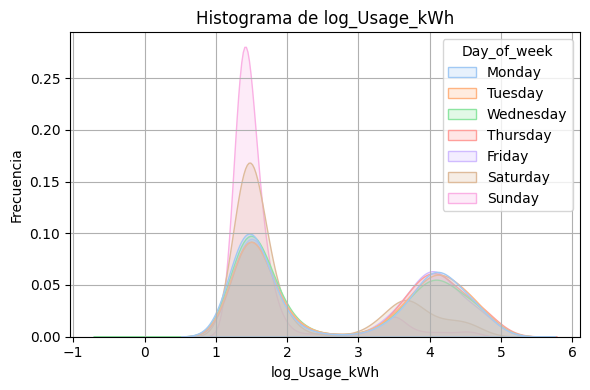

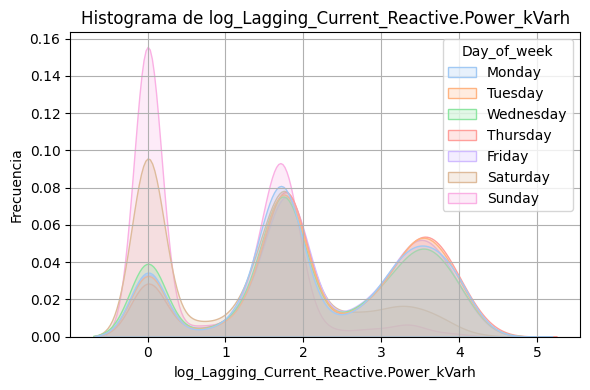

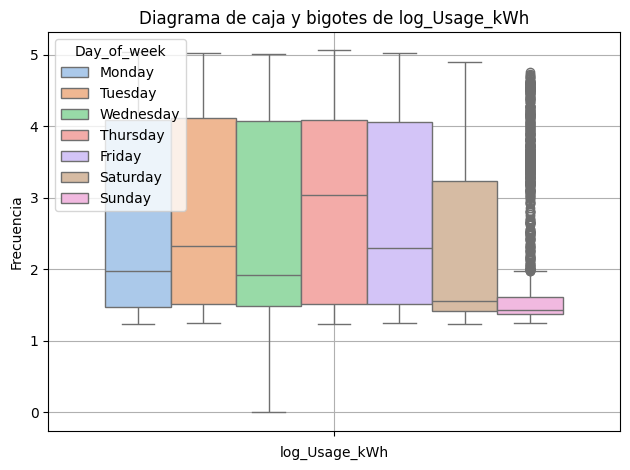

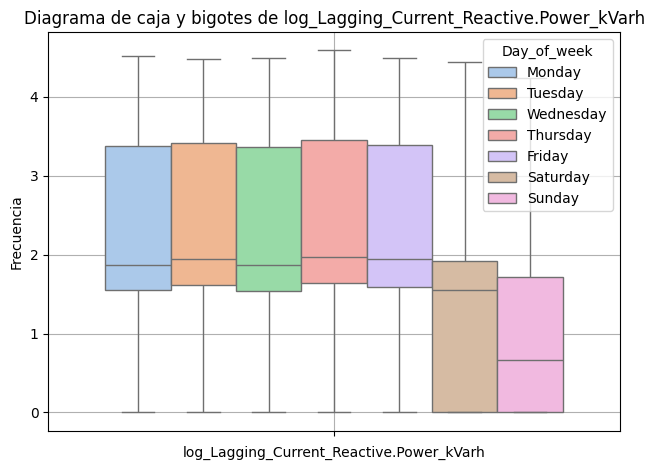

In [ ]:
# Agrupacion con 'Day_of_week'

for col in log_cols:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df, x=col, hue='Day_of_week', fill=True, palette="pastel")
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for col in log_cols:
    sns.boxplot(data=df, y=col, hue='Day_of_week', palette="pastel")
    plt.title(f'Diagrama de caja y bigotes de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Estos graficos muestran que los dias sabado y domingo la planta trabaja menos en terminos de energia.

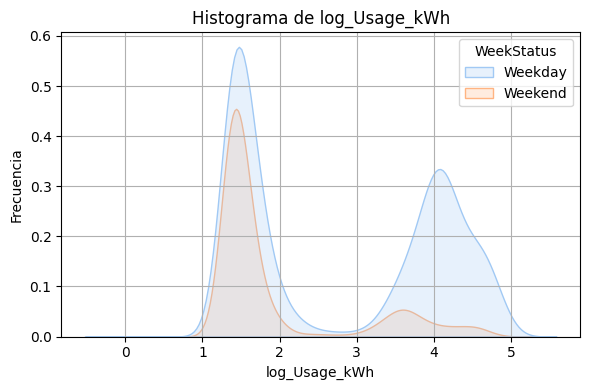

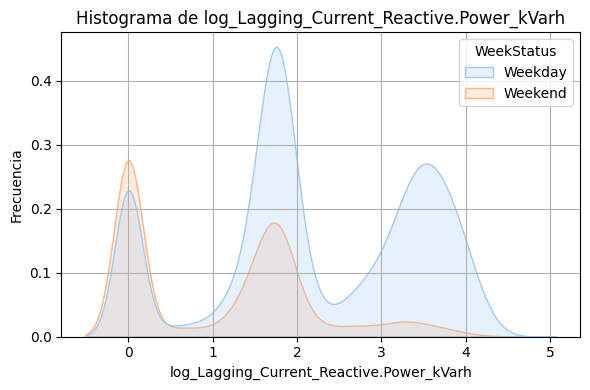

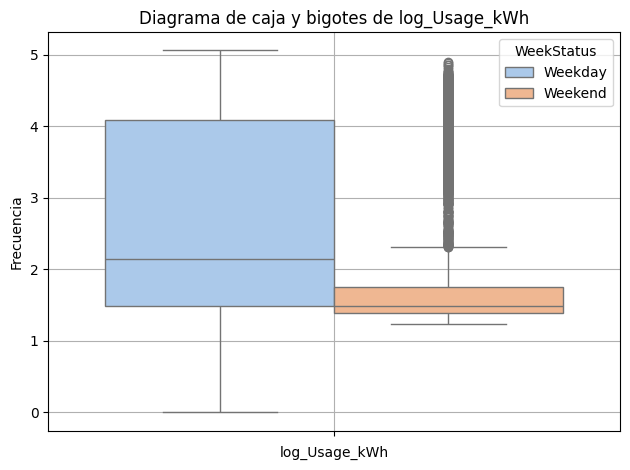

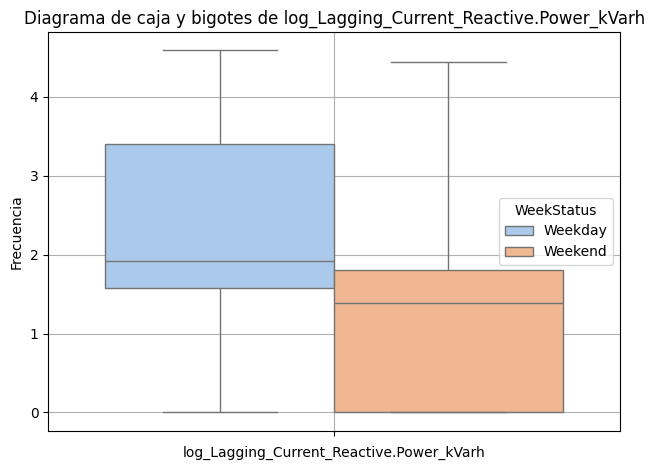

In [ ]:
# Agrupacion con 'WeekStatus'

for col in log_cols:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df, x=col, hue='WeekStatus', fill=True, palette="pastel")
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for col in log_cols:
    sns.boxplot(data=df, y=col, hue='WeekStatus', palette="pastel")
    plt.title(f'Diagrama de caja y bigotes de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Estas graficas presentan resultados parecidos a los anteriores. La produccion de la planta es mas baja para los fines de semana. Sin embargo, se puede evidenciar que el domingo (dia con mas bajo consumo de energia) la planta si trabaja y consume energia como un dia de semana, lo que puede indicar que se trabaja solo una parte del dia.

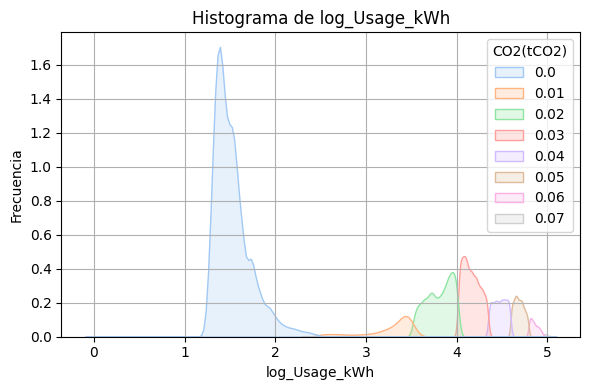

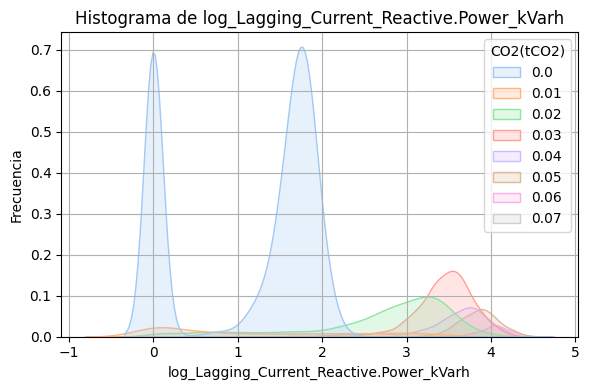

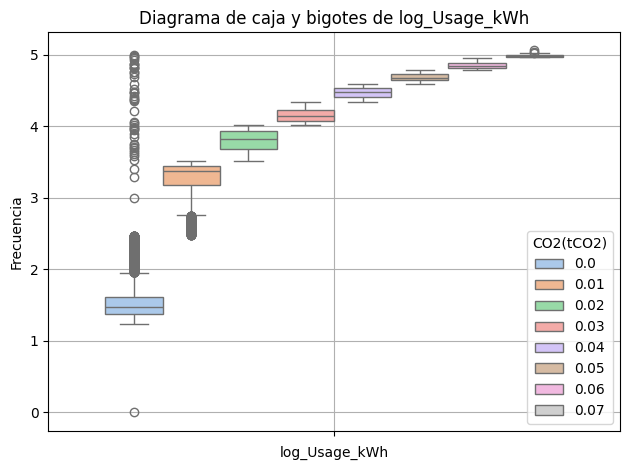

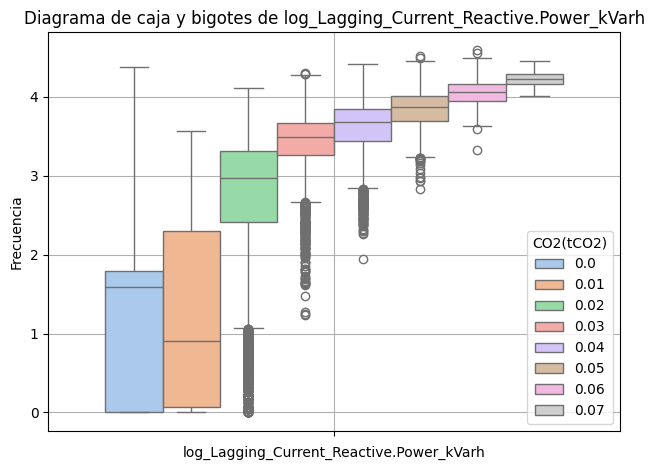

In [ ]:
# Agrupacion con 'CO2(tCO2)'

for col in log_cols:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df, x=col, hue='CO2(tCO2)', fill=True, palette="pastel")
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for col in log_cols:
    sns.boxplot(data=df, y=col, hue='CO2(tCO2)', palette="pastel")
    plt.title(f'Diagrama de caja y bigotes de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Con estos graficos es posible observar como las emisiones de CO2 se incrementan a mas funcionamiento en la planta. Sin embargo, al principio del encendido y uso no prolongado de las maquinas puede que estas no emitan CO2, lo que puede explicar los outliers del primer caso.

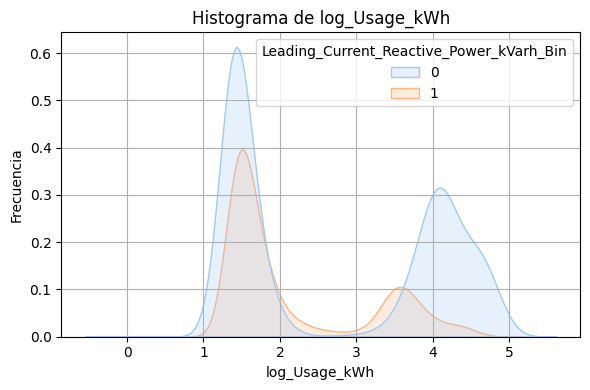

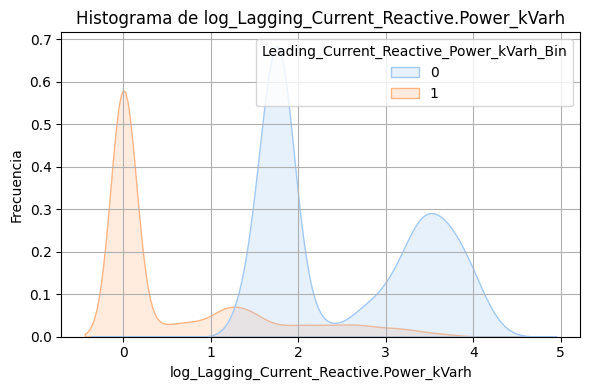

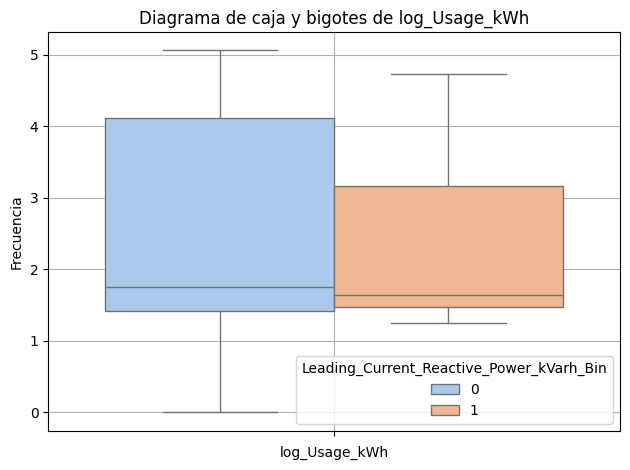

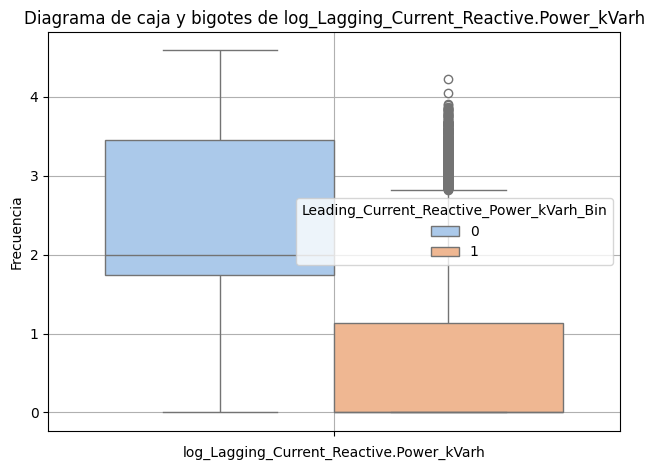

In [ ]:
# Agrupacion con 'Leading_Current_Reactive_Power_kVarh'

for col in log_cols:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df, x=col, hue='Leading_Current_Reactive_Power_kVarh_Bin', fill=True, palette="pastel")
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for col in log_cols:
    sns.boxplot(data=df, y=col, hue='Leading_Current_Reactive_Power_kVarh_Bin', palette="pastel")
    plt.title(f'Diagrama de caja y bigotes de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

En este caso, la variable discreta de 'Leading_Current_Reactive_Power_kVarh_Bin' describe bien los movimientos para el objetivo.

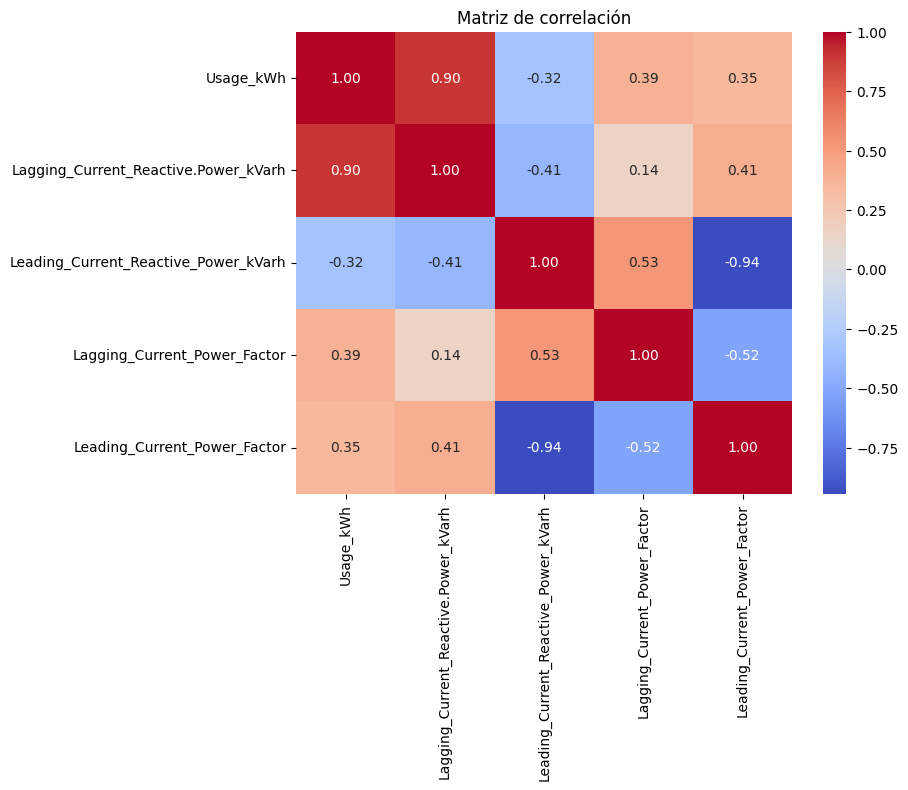

In [ ]:
# ==================================
# Analisis multivariado cuantitativo
# ==================================

# Realizando un mapa de calor de las varibales numericas
matrix_df = df[['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
                'Leading_Current_Reactive_Power_kVarh',
                'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor']]
plt.figure(figsize=(8,6))
sns.heatmap(matrix_df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación')
plt.show()

La matriz muestra que la mejor variable para predecir el target es  'Lagging_Current_Reactive.Power_kVarh'

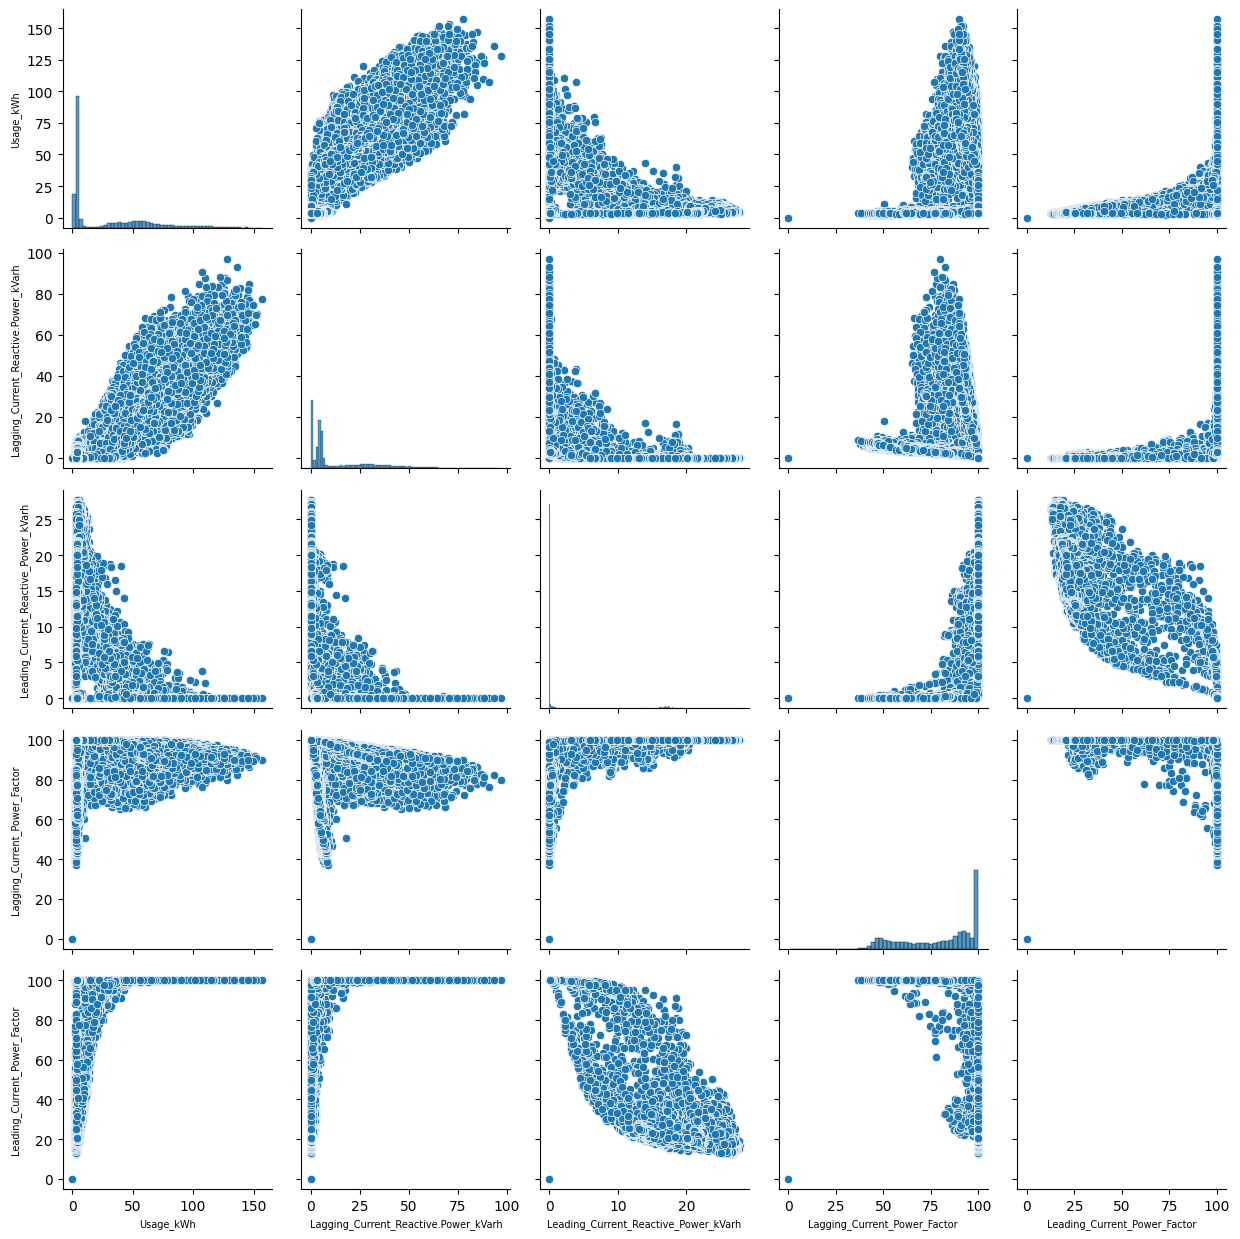

In [ ]:
# Graficos de dispersion

# Realizando garficos de dispersion para las variables
g = sns.pairplot(matrix_df)

for ax in g.axes.flatten():
    if ax is not None:
        ax.set_xlabel(ax.get_xlabel(), fontsize=7)
        ax.set_ylabel(ax.get_ylabel(), fontsize=7)

plt.tight_layout()
plt.show()

Con la dispersion se puede ver lo que se confirmo anteriormente.

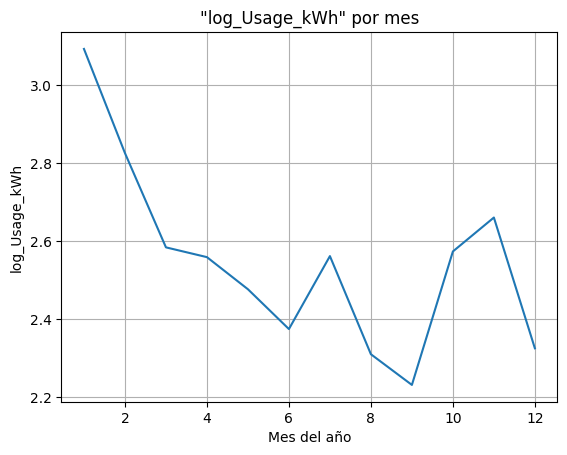

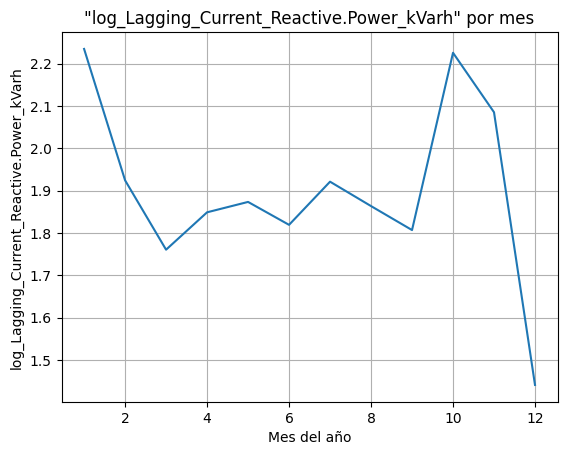

In [ ]:
# =================
# Graficos de linea
# =================

# Meses para 'log_Usage_KWh'
sns.lineplot(data=df, x='month', y='log_Usage_kWh', errorbar=None)
plt.title('"log_Usage_kWh" por mes')
plt.xlabel('Mes del año')
plt.ylabel('log_Usage_kWh')
plt.grid()
plt.show()

# Meses para 'log_Lagging_Current_Reactive.Power_kVarh'
sns.lineplot(data=df, x='month', y='log_Lagging_Current_Reactive.Power_kVarh', errorbar=None)
plt.title('"log_Lagging_Current_Reactive.Power_kVarh" por mes')
plt.xlabel('Mes del año')
plt.ylabel('log_Lagging_Current_Reactive.Power_kVarh')
plt.grid()
plt.show()

Con ambas graficas se puede observar que a traves de un año el consumo tiende a la baja hasta llegar a los ultimo smeses del año donde vuleve a subir para luego bajar. Estos movimientos pueden estar dados por las distintas epocas del año para una empresa.

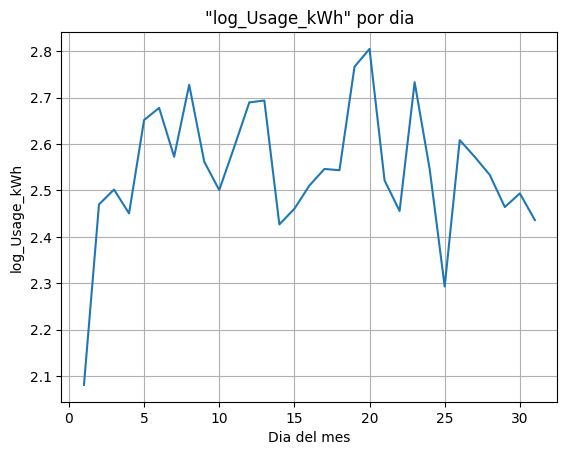

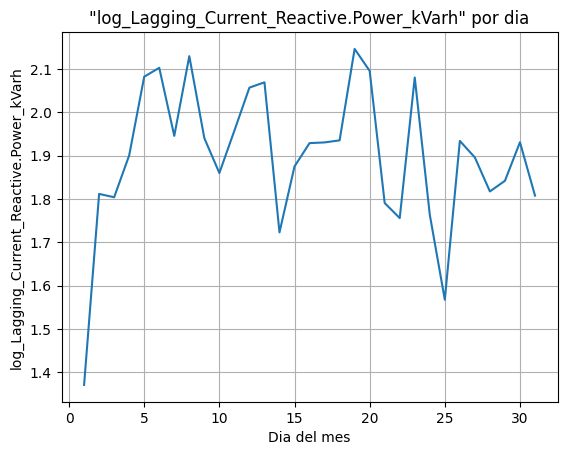

In [ ]:
# Dias para 'log_Usage_KWh'
sns.lineplot(data=df, x='day', y='log_Usage_kWh', errorbar=None)
plt.title('"log_Usage_kWh" por dia')
plt.xlabel('Dia del mes')
plt.ylabel('log_Usage_kWh')
plt.grid()
plt.show()

# Dias para 'log_Lagging_Current_Reactive.Power_kVarh'
sns.lineplot(data=df, x='day', y='log_Lagging_Current_Reactive.Power_kVarh', errorbar=None)
plt.title('"log_Lagging_Current_Reactive.Power_kVarh" por dia')
plt.xlabel('Dia del mes')
plt.ylabel('log_Lagging_Current_Reactive.Power_kVarh')
plt.grid()
plt.show()

Las graficas de la distribucion para los dias muestra una diferencia para los principios de mes y fines de mes. De nuevo, esto puede estar dado por las formas de trabajo para esta empresa.

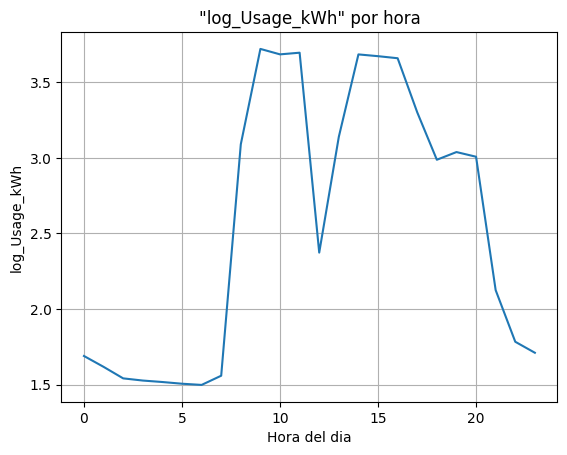

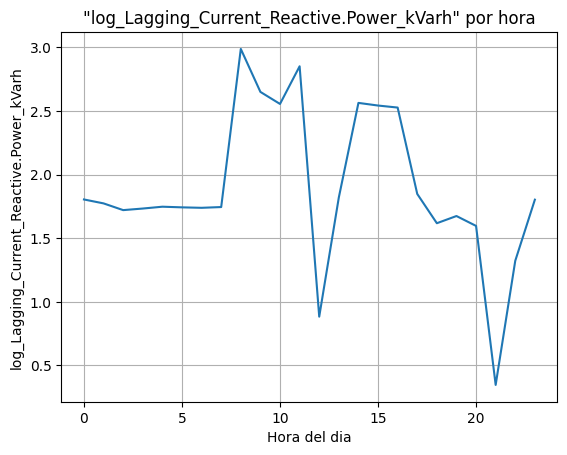

In [ ]:
# Horas para 'log_Usage_KWh'
sns.lineplot(data=df, x='hour', y='log_Usage_kWh', errorbar=None)
plt.title('"log_Usage_kWh" por hora')
plt.xlabel('Hora del dia')
plt.ylabel('log_Usage_kWh')
plt.grid()
plt.show()

# Horas para 'log_Lagging_Current_Reactive.Power_kVarh'
sns.lineplot(data=df, x='hour', y='log_Lagging_Current_Reactive.Power_kVarh', errorbar=None)
plt.title('"log_Lagging_Current_Reactive.Power_kVarh" por hora')
plt.xlabel('Hora del dia')
plt.ylabel('log_Lagging_Current_Reactive.Power_kVarh')
plt.grid()
plt.show()

Ambas graficas muestran una mejor distribucion del consumo a lo largo del dia. La hora de trabajo para la industria parece ser algo cercano a las 08:00 horas. Este punto es donde se muestra el mayor consumo. El consumo mas bajo esta presente en horarios de descanso para el personal de una planta (12:00 y en las noches).

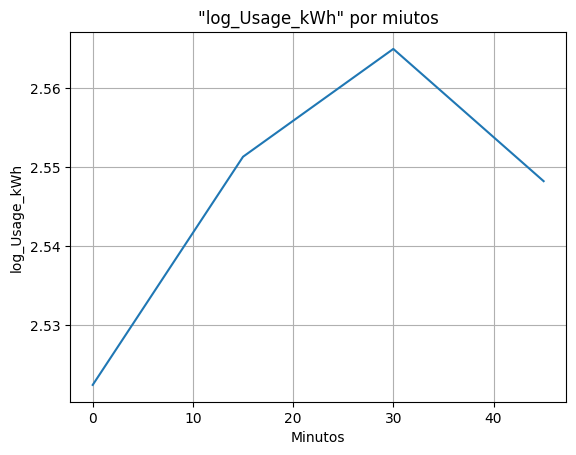

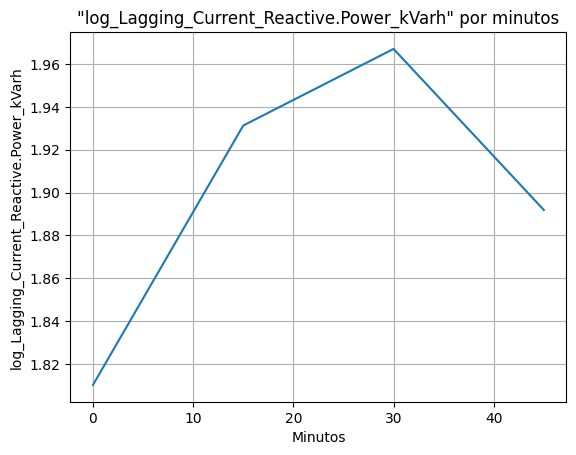

In [ ]:
# Minutos para 'log_Usage_KWh'
sns.lineplot(data=df, x='minute', y='log_Usage_kWh', errorbar=None)
plt.title('"log_Usage_kWh" por miutos')
plt.xlabel('Minutos')
plt.ylabel('log_Usage_kWh')
plt.grid()
plt.show()

# Minutos para 'log_Lagging_Current_Reactive.Power_kVarh'
sns.lineplot(data=df, x='minute', y='log_Lagging_Current_Reactive.Power_kVarh', errorbar=None)
plt.title('"log_Lagging_Current_Reactive.Power_kVarh" por minutos')
plt.xlabel('Minutos')
plt.ylabel('log_Lagging_Current_Reactive.Power_kVarh')
plt.grid()
plt.show()

Dado que las anteriores graficas estan en minutos, estas no dan una informacion clara, ya que como se vio anteriormente las horas del dia presentan mucha diferencia dependiendo del funcionamiento de la planta. Por lo tanto, los minutos no seran tomados en cuenta en el analisis.

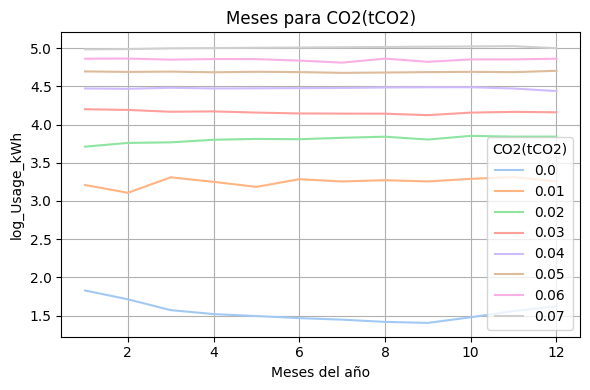

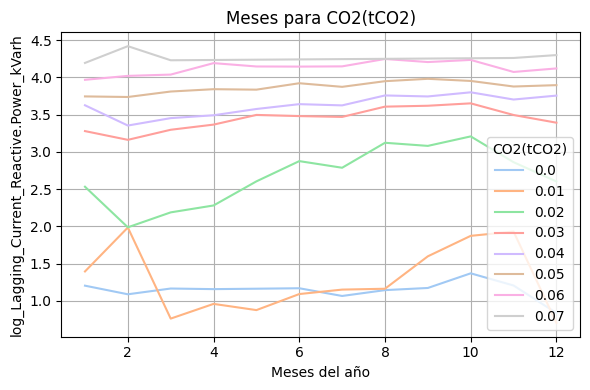

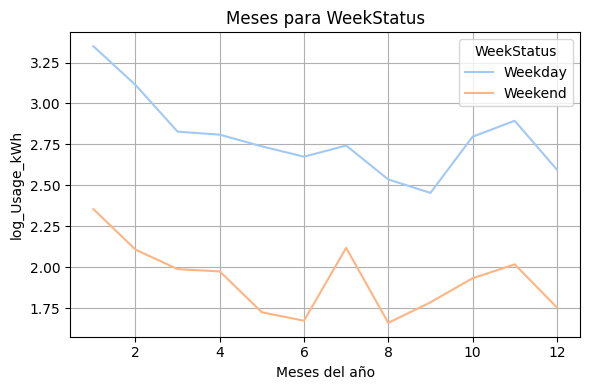

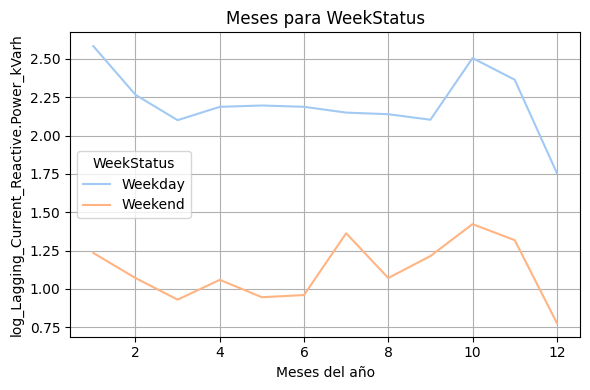

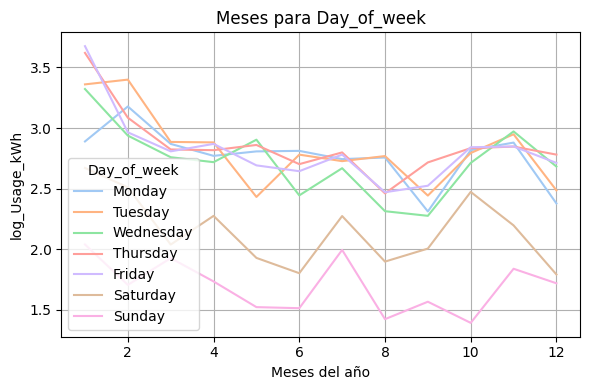

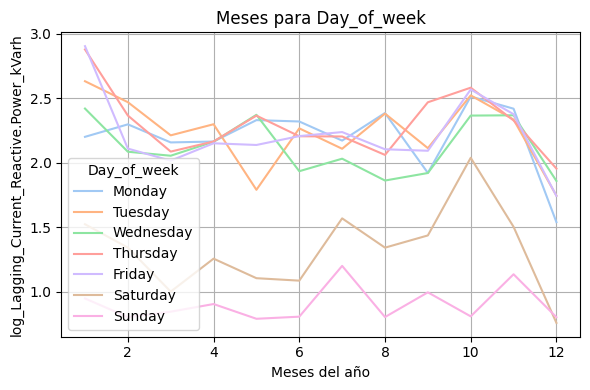

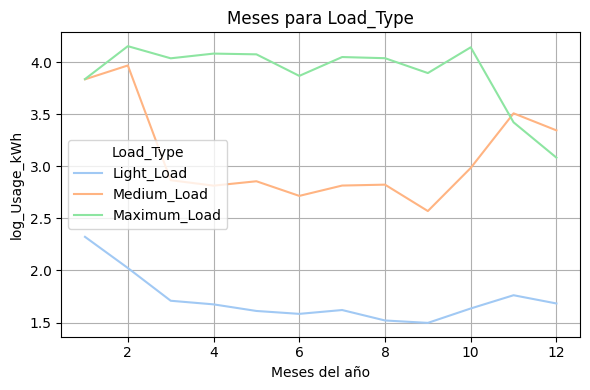

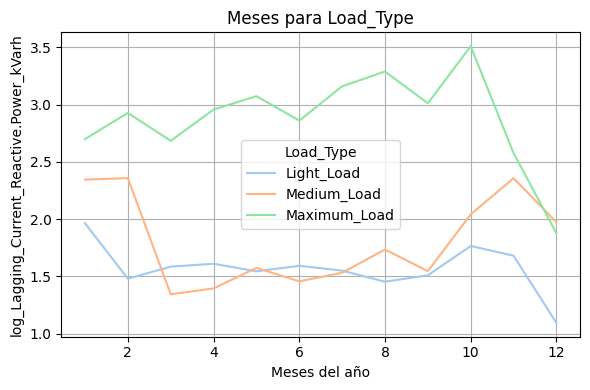

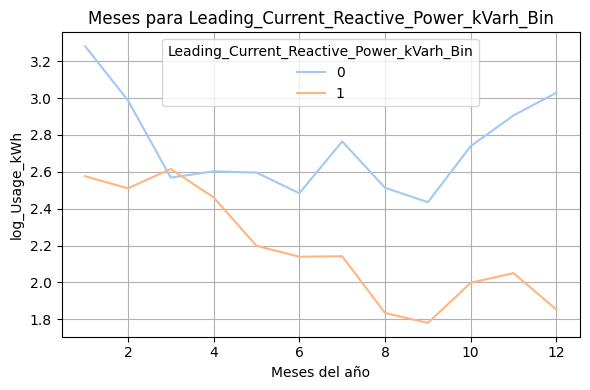

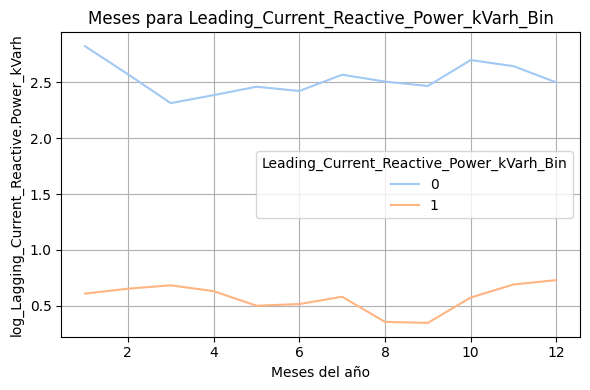

In [ ]:
# Incluyendo variables categoricas

col_time = df[['CO2(tCO2)', 'WeekStatus', 'Day_of_week', 'Load_Type',
               'Leading_Current_Reactive_Power_kVarh_Bin',]]
targ_time = df[['log_Usage_kWh', 'log_Lagging_Current_Reactive.Power_kVarh']]

# Agrupacion para meses
for col in col_time:
  for target in targ_time:
      plt.figure(figsize=(6, 4))
      sns.lineplot(data=df, x='month', y=target, hue=col, errorbar=None, palette="pastel")
      plt.title(f'Meses para {col}')
      plt.xlabel('Meses del año')
      plt.ylabel(f'{target}')
      plt.grid(True)
      plt.tight_layout()
      plt.show()

Los graficos agrupados por 'month' confirman los resultados mencionados anteriormente en el analisis.

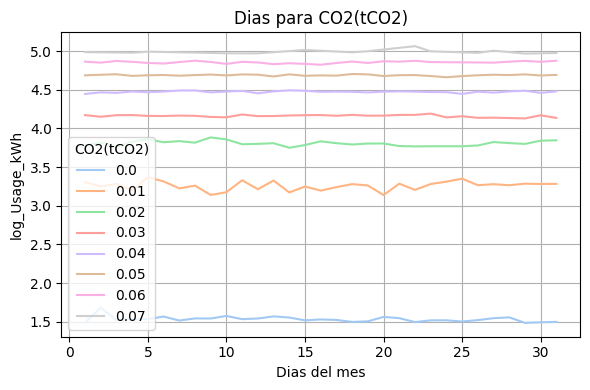

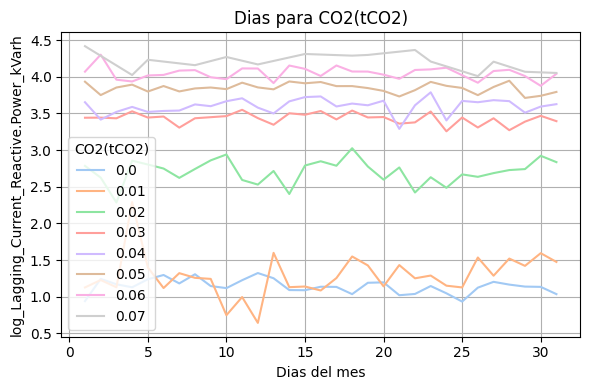

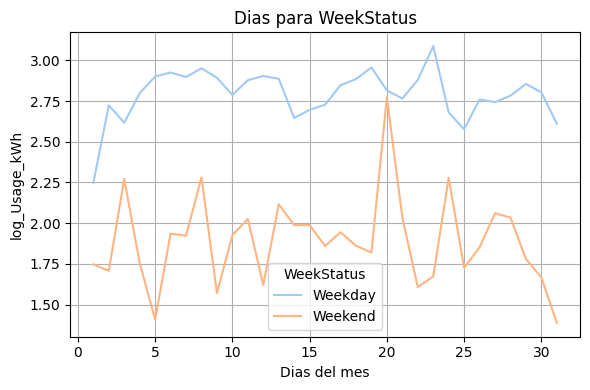

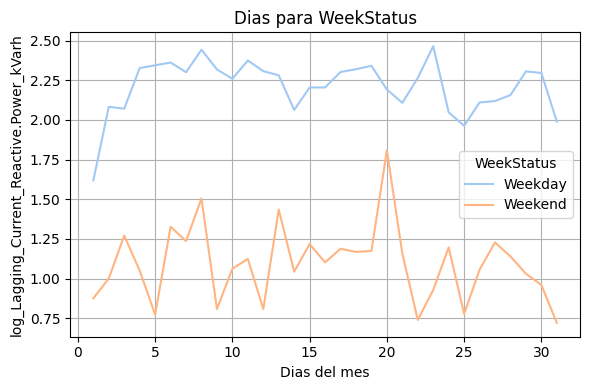

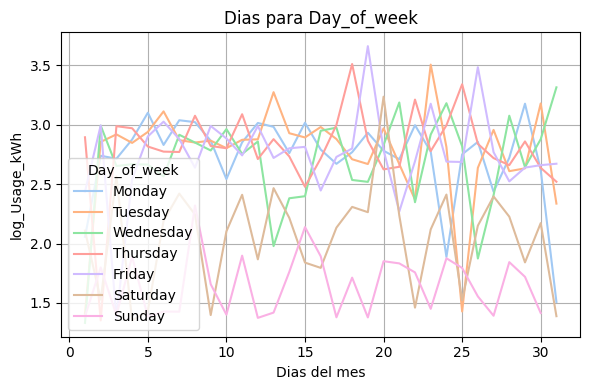

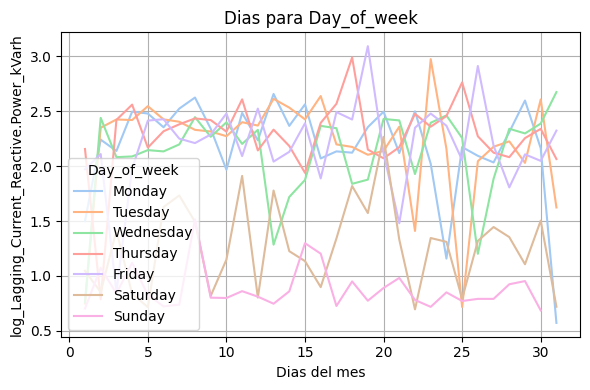

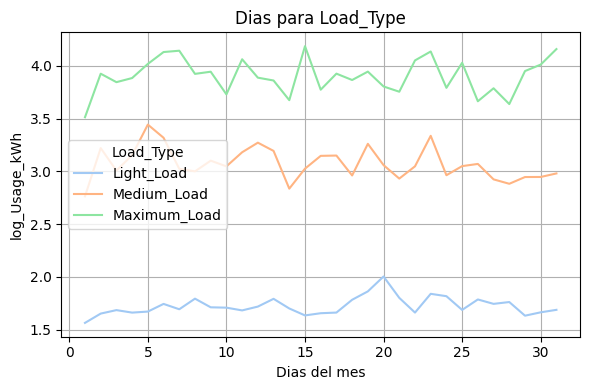

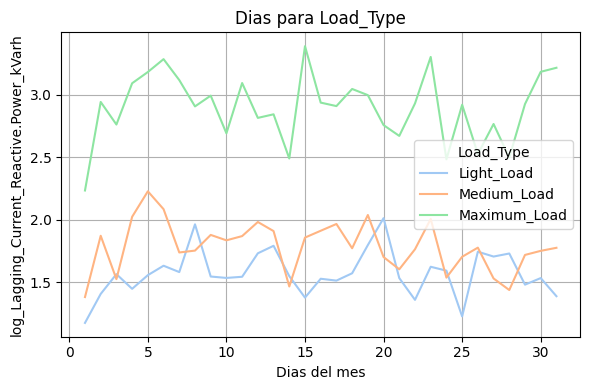

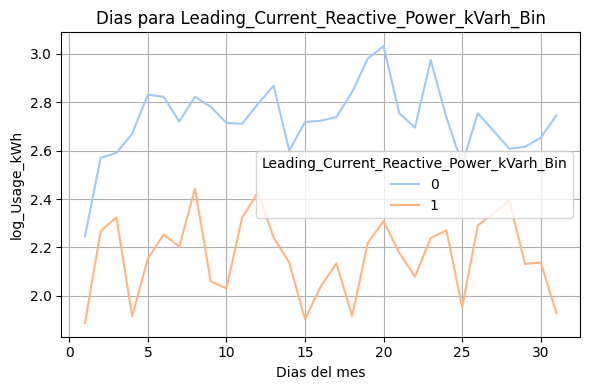

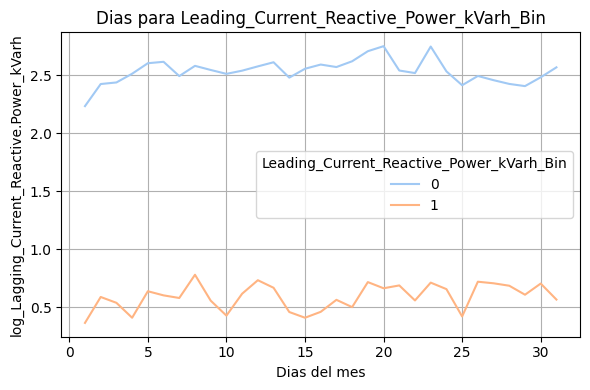

In [ ]:
# Agrupacion para dias

for col in col_time:
  for target in targ_time:
      plt.figure(figsize=(6, 4))
      sns.lineplot(data=df, x='day', y=target, hue=col, errorbar=None, palette="pastel")
      plt.title(f'Dias para {col}')
      plt.xlabel('Dias del mes')
      plt.ylabel(f'{target}')
      plt.grid(True)
      plt.tight_layout()
      plt.show()

Los graficos agrupados por 'day' confirman los resultados mencionados anteriormente en el analisis. Sin embargo, es importante notar como en el grafico de 'Day_of_week' los dias de la semana se sobreponen, esto porque los fines de semana varian independientente del dia del mes que se trate. Igualmente, esta agrupacion describe de forma acertada los resultados presentes en este analisis.

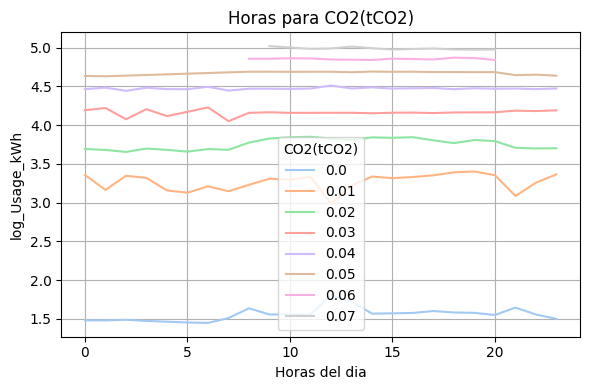

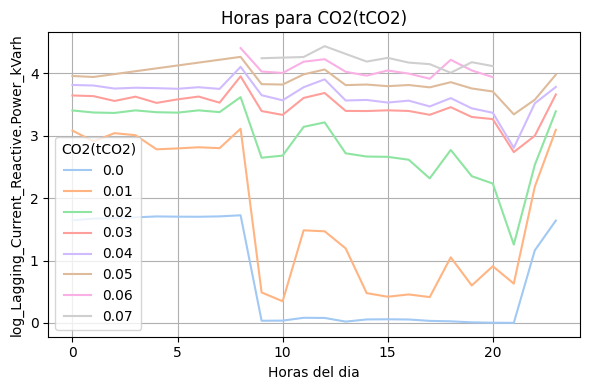

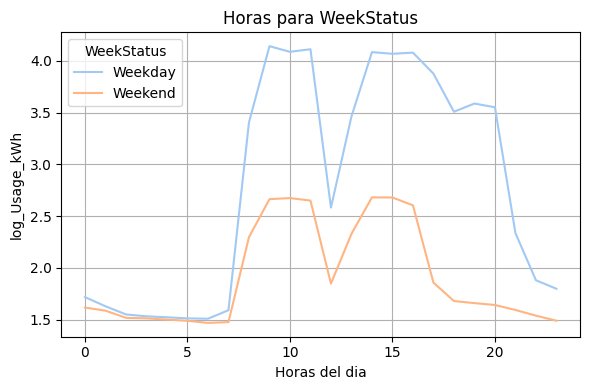

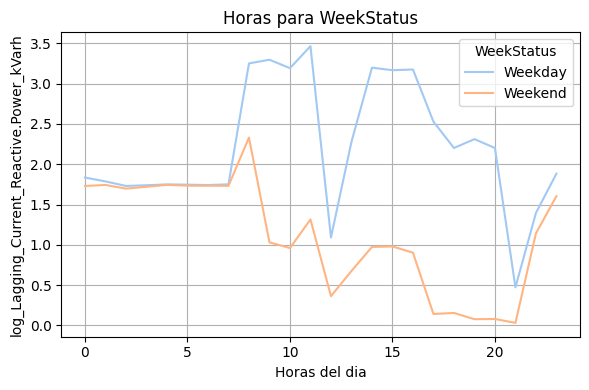

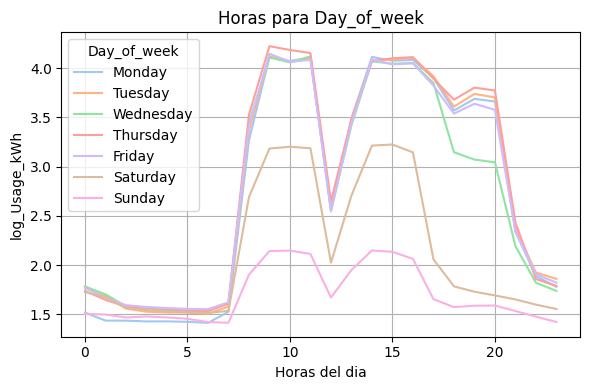

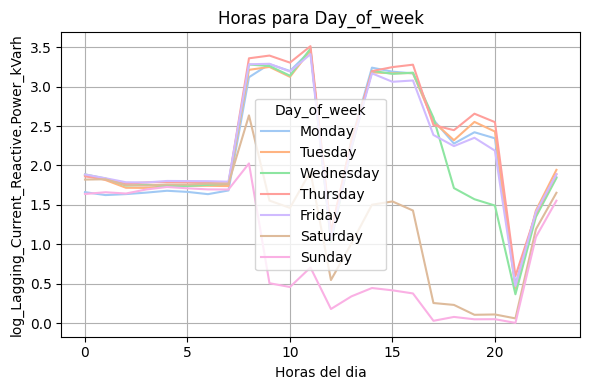

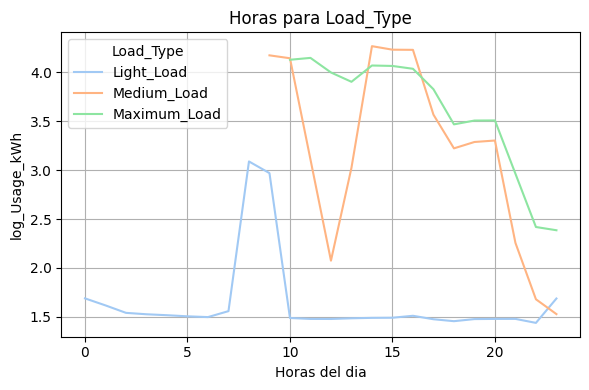

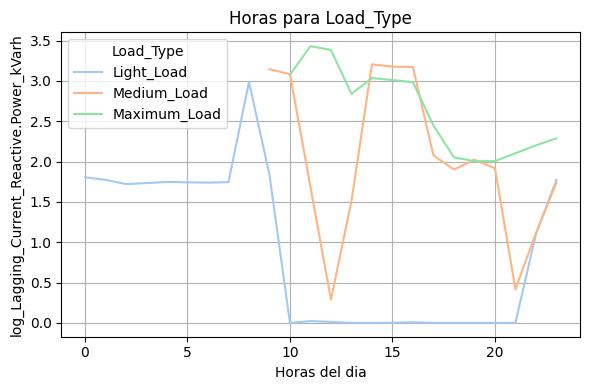

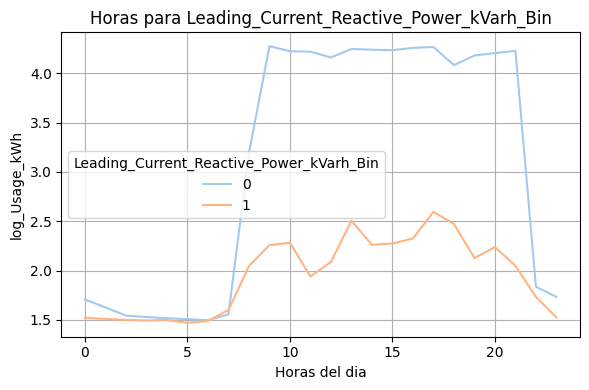

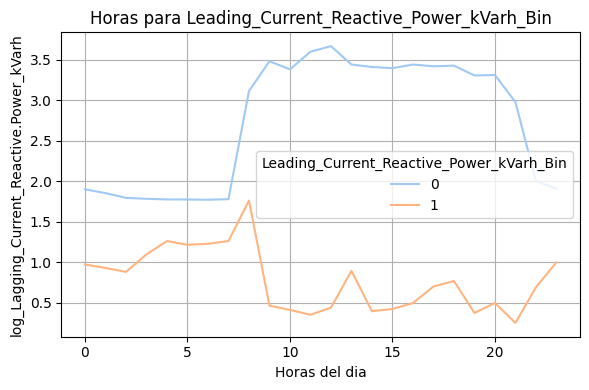

In [ ]:
# Agrupacion para horas

for col in col_time:
  for target in targ_time:
      plt.figure(figsize=(6, 4))
      sns.lineplot(data=df, x='hour', y=target, hue=col, errorbar=None, palette="pastel")
      plt.title(f'Horas para {col}')
      plt.xlabel('Horas del dia')
      plt.ylabel(f'{target}')
      plt.grid(True)
      plt.tight_layout()
      plt.show()

Con los anteriores graficos se presenta un caso similar que en la agrupacion para dias. En graficos como 'Day_of_week' las lineas parecen sobreponerse y no mostrar nada en forma de respuesta. Sin embargo, aun asi estos grafico siguen confirmando los resultados demostrados anteriormente.

Con toda la informacion adquirida hasta el momento ya es posible pasar al siguiente punto del analisis.

In [ ]:
# ====================================
# Prediccion mediante Machine Learning
# ====================================

# Usando el df inicial para el modelo de ML
df_ML = df[['date', 'Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'WeekStatus', 'Day_of_week', 'Load_Type']]

# Creando un df para entrenar y otro para comprobar
X = df_ML.drop('Usage_kWh', axis=1)
y = df_ML['Usage_kWh']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
y_train = y_train.to_frame()
y_test = y_test.to_frame()
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")
print(f"Forma de y_train: {y_train.shape}")
print(f"Forma de y_test: {y_test.shape}")

Forma de X_train: (24528, 7)
Forma de X_test: (10512, 7)
Forma de y_train: (24528, 1)
Forma de y_test: (10512, 1)


In [ ]:
# ===============================
# Preprocesamiento para el modelo
# ===============================

# Aplicando logaritmos a 'Usage_kWh' y 'Lagging_Current_Reactive.Power_kVarh'
y_train['log_Usage_kWh'] = np.log1p(y_train['Usage_kWh'])
y_test['log_Usage_kWh'] = np.log1p(y_test['Usage_kWh'])
X_train['log_Lagging_Current_Reactive.Power_kVarh'] = np.log1p(X_train['Lagging_Current_Reactive.Power_kVarh'])
X_test['log_Lagging_Current_Reactive.Power_kVarh'] = np.log1p(X_test['Lagging_Current_Reactive.Power_kVarh'])

# Aplicano binariedad a 'Leading_Current_Reactive_Power_kVarh'
X_train['Leading_Current_Reactive_Power_kVarh_Bin'] = (df['Leading_Current_Reactive_Power_kVarh'] > 0).astype(int)
X_test['Leading_Current_Reactive_Power_kVarh_Bin'] = (df['Leading_Current_Reactive_Power_kVarh'] > 0).astype(int)

# Eliminando las columnas que no se usaran en el modelo
X_train = X_train.drop(['Lagging_Current_Reactive.Power_kVarh','Leading_Current_Reactive_Power_kVarh'], axis=1)
X_test = X_test.drop(['Lagging_Current_Reactive.Power_kVarh','Leading_Current_Reactive_Power_kVarh'], axis=1)
y_train = y_train.drop('Usage_kWh', axis=1)
y_test = y_test.drop('Usage_kWh', axis=1)

display(X_train.columns)
display(X_train.columns)

Index(['date', 'CO2(tCO2)', 'WeekStatus', 'Day_of_week', 'Load_Type',
       'log_Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh_Bin'],
      dtype='object')

Index(['date', 'CO2(tCO2)', 'WeekStatus', 'Day_of_week', 'Load_Type',
       'log_Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh_Bin'],
      dtype='object')

In [ ]:
# Preparando los datos temporales en forma ciclica

date = 'date'
X_train['date'] = pd.to_datetime(X_train['date'], errors='coerce')
X_test['date'] = pd.to_datetime(X_test['date'], errors='coerce')

# Para X_train
X_train['month_sin'] = np.sin(2 * np.pi * X_train['date'].dt.month / 12)
X_train['month_cos'] = np.cos(2 * np.pi * X_train['date'].dt.month / 12)
X_train['day_sin'] = np.sin(2 * np.pi * X_train['date'].dt.dayofweek / 31)
X_train['day_cos'] = np.cos(2 * np.pi * X_train['date'].dt.dayofweek / 31)
X_train['hour_sin'] = np.sin(2 * np.pi * X_train['date'].dt.hour / 24)
X_train['hour_cos'] = np.cos(2 * np.pi * X_train['date'].dt.hour / 24)

# Para X_test
X_test['month_sin'] = np.sin(2 * np.pi * X_test['date'].dt.month / 12)
X_test['month_cos'] = np.cos(2 * np.pi * X_test['date'].dt.month / 12)
X_test['day_sin'] = np.sin(2 * np.pi * X_test['date'].dt.dayofweek / 31)
X_test['day_cos'] = np.cos(2 * np.pi * X_test['date'].dt.dayofweek / 31)
X_test['hour_sin'] = np.sin(2 * np.pi * X_test['date'].dt.hour / 24)
X_test['hour_cos'] = np.cos(2 * np.pi * X_test['date'].dt.hour / 24)

# Eliminando las columnas que no se usaran en el modelo
X_train = X_train.drop(['date'], axis=1)
X_test = X_test.drop(['date'], axis=1)

display(X_train.head())
display(X_train.columns)

CO2(tCO2) WeekStatus Day_of_week     Load_Type  \
24510       0.00    Weekday    Thursday    Light_Load   
11355       0.00    Weekend      Sunday    Light_Load   
32539       0.00    Weekday   Wednesday  Maximum_Load   
18663       0.02    Weekend    Saturday   Medium_Load   
33094       0.01    Weekday     Tuesday  Maximum_Load   

       log_Lagging_Current_Reactive.Power_kVarh  \
24510                                  1.834180   
11355                                  1.556037   
32539                                  1.650580   
18663                                  0.978326   
33094                                  0.000000   

       Leading_Current_Reactive_Power_kVarh_Bin     month_sin     month_cos  \
24510                                         0 -1.000000e+00 -1.836970e-16   
11355                                         0  8.660254e-01 -5.000000e-01   
32539                                         0 -2.449294e-16  1.000000e+00   
18663                                         1 -5.000000e-01 -8.660254e-01   
33094                                         1 -2.449294e-16  1.000000e+00   

        day_sin   day_cos  hour_sin  hour_cos  
24510  0.571268  0.820763  0.965926 -0.258819  
11355  0.937752  0.347305  0.965926 -0.258819  
32539  0.394356  0.918958 -0.258819  0.965926  
18663  0.848644  0.528964  0.500000 -0.866025  
33094  0.201299  0.979530 -0.965926 -0.258819

Index(['CO2(tCO2)', 'WeekStatus', 'Day_of_week', 'Load_Type',
       'log_Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh_Bin', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'hour_sin', 'hour_cos'],
      dtype='object')

In [ ]:
# Codificando las variables categoricas sin jerarquia

# Variables categoricas para one hot encoding
col_cat_ML = ['WeekStatus', 'Day_of_week']
encoder_hot = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')

# Para X_train
encoded_train_features = encoder_hot.fit_transform(X_train[col_cat_ML])
encoded_train_df = pd.DataFrame(encoded_train_features,
                                columns=encoder_hot.get_feature_names_out(col_cat_ML),
                                index=X_train.index)

# Para X_test
encoded_test_features = encoder_hot.transform(X_test[col_cat_ML])
encoded_test_df = pd.DataFrame(encoded_test_features,
                               columns=encoder_hot.get_feature_names_out(col_cat_ML),
                               index=X_test.index)

X_train = pd.concat([X_train.drop(columns=col_cat_ML), encoded_train_df], axis=1)
X_test = pd.concat([X_test.drop(columns=col_cat_ML), encoded_test_df], axis=1)

display(X_train.head())
display(X_train.columns)

CO2(tCO2)     Load_Type  log_Lagging_Current_Reactive.Power_kVarh  \
24510       0.00    Light_Load                                  1.834180   
11355       0.00    Light_Load                                  1.556037   
32539       0.00  Maximum_Load                                  1.650580   
18663       0.02   Medium_Load                                  0.978326   
33094       0.01  Maximum_Load                                  0.000000   

       Leading_Current_Reactive_Power_kVarh_Bin     month_sin     month_cos  \
24510                                         0 -1.000000e+00 -1.836970e-16   
11355                                         0  8.660254e-01 -5.000000e-01   
32539                                         0 -2.449294e-16  1.000000e+00   
18663                                         1 -5.000000e-01 -8.660254e-01   
33094                                         1 -2.449294e-16  1.000000e+00   

        day_sin   day_cos  hour_sin  hour_cos  WeekStatus_Weekend  \
24510  0.571268  0.820763  0.965926 -0.258819                 0.0   
11355  0.937752  0.347305  0.965926 -0.258819                 1.0   
32539  0.394356  0.918958 -0.258819  0.965926                 0.0   
18663  0.848644  0.528964  0.500000 -0.866025                 1.0   
33094  0.201299  0.979530 -0.965926 -0.258819                 0.0   

       Day_of_week_Monday  Day_of_week_Saturday  Day_of_week_Sunday  \
24510                 0.0                   0.0                 0.0   
11355                 0.0                   0.0                 1.0   
32539                 0.0                   0.0                 0.0   
18663                 0.0                   1.0                 0.0   
33094                 0.0                   0.0                 0.0   

       Day_of_week_Thursday  Day_of_week_Tuesday  Day_of_week_Wednesday  
24510                   1.0                  0.0                    0.0  
11355                   0.0                  0.0                    0.0  
32539                   0.0                  0.0                    1.0  
18663                   0.0                  0.0                    0.0  
33094                   0.0                  1.0                    0.0

Index(['CO2(tCO2)', 'Load_Type', 'log_Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh_Bin', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'WeekStatus_Weekend',
       'Day_of_week_Monday', 'Day_of_week_Saturday', 'Day_of_week_Sunday',
       'Day_of_week_Thursday', 'Day_of_week_Tuesday', 'Day_of_week_Wednesday'],
      dtype='object')

In [ ]:
# Codificado de variables categoricas con jerarquia

# Dando un orden para OrdinalEncoder
order_Load = ['Light_Load', 'Medium_Load', 'Maximum_Load']
encoder_os = OrdinalEncoder(categories=[order_Load], handle_unknown='use_encoded_value',
                                          unknown_value=-1)

# Para X_train
X_train['Load_Type'] = encoder_os.fit_transform(X_train[['Load_Type']])

# Para X_test
X_test['Load_Type'] = encoder_os.transform(X_test[['Load_Type']])

display(X_train.head())

CO2(tCO2)  Load_Type  log_Lagging_Current_Reactive.Power_kVarh  \
24510       0.00        0.0                                  1.834180   
11355       0.00        0.0                                  1.556037   
32539       0.00        2.0                                  1.650580   
18663       0.02        1.0                                  0.978326   
33094       0.01        2.0                                  0.000000   

       Leading_Current_Reactive_Power_kVarh_Bin     month_sin     month_cos  \
24510                                         0 -1.000000e+00 -1.836970e-16   
11355                                         0  8.660254e-01 -5.000000e-01   
32539                                         0 -2.449294e-16  1.000000e+00   
18663                                         1 -5.000000e-01 -8.660254e-01   
33094                                         1 -2.449294e-16  1.000000e+00   

        day_sin   day_cos  hour_sin  hour_cos  WeekStatus_Weekend  \
24510  0.571268  0.820763  0.965926 -0.258819                 0.0   
11355  0.937752  0.347305  0.965926 -0.258819                 1.0   
32539  0.394356  0.918958 -0.258819  0.965926                 0.0   
18663  0.848644  0.528964  0.500000 -0.866025                 1.0   
33094  0.201299  0.979530 -0.965926 -0.258819                 0.0   

       Day_of_week_Monday  Day_of_week_Saturday  Day_of_week_Sunday  \
24510                 0.0                   0.0                 0.0   
11355                 0.0                   0.0                 1.0   
32539                 0.0                   0.0                 0.0   
18663                 0.0                   1.0                 0.0   
33094                 0.0                   0.0                 0.0   

       Day_of_week_Thursday  Day_of_week_Tuesday  Day_of_week_Wednesday  
24510                   1.0                  0.0                    0.0  
11355                   0.0                  0.0                    0.0  
32539                   0.0                  0.0                    1.0  
18663                   0.0                  0.0                    0.0  
33094                   0.0                  1.0                    0.0

In [ ]:
# Multicolinealidad

vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns

# Obteniendo el VIF para las variables
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]

display(vif_data.sort_values(by="VIF", ascending=False))

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


feature       VIF
7                                    day_cos       inf
16                     Day_of_week_Wednesday       inf
6                                    day_sin       inf
14                      Day_of_week_Thursday       inf
15                       Day_of_week_Tuesday       inf
13                        Day_of_week_Sunday       inf
12                      Day_of_week_Saturday       inf
11                        Day_of_week_Monday       inf
10                        WeekStatus_Weekend       inf
2   log_Lagging_Current_Reactive.Power_kVarh  8.199137
0                                  CO2(tCO2)  5.803080
3   Leading_Current_Reactive_Power_kVarh_Bin  3.686856
1                                  Load_Type  2.514743
8                                   hour_sin  2.306857
9                                   hour_cos  1.957733
4                                  month_sin  1.042582
5                                  month_cos  1.024033

Existe una multicolinealidad perfecta, por lo tanto se eliminara 'WeekStatus_Weekend'

In [ ]:
# Eliminando variables que sobrerespresentan

X_train = X_train.drop(['WeekStatus_Weekend', 'Day_of_week_Monday', 'Day_of_week_Saturday', 'Day_of_week_Sunday',
       'Day_of_week_Thursday', 'Day_of_week_Tuesday', 'Day_of_week_Wednesday'], axis=1)
X_test = X_test.drop(['WeekStatus_Weekend', 'Day_of_week_Monday', 'Day_of_week_Saturday', 'Day_of_week_Sunday',
       'Day_of_week_Thursday', 'Day_of_week_Tuesday', 'Day_of_week_Wednesday'], axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns

# Obteniendo el VIF para las variables
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
print(vif_data.sort_values(by="VIF", ascending=False))

                                    feature        VIF
2  log_Lagging_Current_Reactive.Power_kVarh  24.838771
7                                   day_cos  11.688140
0                                 CO2(tCO2)   8.579515
3  Leading_Current_Reactive_Power_kVarh_Bin   5.205644
1                                 Load_Type   4.352676
6                                   day_sin   3.812647
8                                  hour_sin   2.301145
9                                  hour_cos   1.951127
4                                 month_sin   1.041656
5                                 month_cos   1.023815


In [ ]:
# ===================
# Seleccion de modelo
# ===================

model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f"El error cuadratico medio (MSE) es: {mse:.2f}")
print(f"La raiz del error cuadrático Medio (RMSE): {rmse:.2f}")
print(f"El coeficiente de determinacion (R-cuadrado): {r2:.2f}")

El error cuadratico medio (MSE) es: 0.10
La raiz del error cuadrático Medio (RMSE): 0.32
El coeficiente de determinacion (R-cuadrado): 0.94


In [ ]:
# Obteniendo los nombres de las variables
feature_names = X_train.columns

# Obteniendo los coeficientes
coefficients = model.coef_.flatten()
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coeficiente': coefficients
}).sort_values(by='Coeficiente', key=abs, ascending=False)

# Obteniendo los coeficientes para la regresion
print(coef_df)

                                    Feature  Coeficiente
0                                 CO2(tCO2)    39.221552
3  Leading_Current_Reactive_Power_kVarh_Bin     0.442104
2  log_Lagging_Current_Reactive.Power_kVarh     0.407535
7                                   day_cos     0.337687
9                                  hour_cos    -0.211478
1                                 Load_Type     0.197169
8                                  hour_sin    -0.183812
6                                   day_sin     0.158925
4                                 month_sin     0.104882
5                                 month_cos     0.059204


Ya que las emisiones de CO2 estan dadas por el funcionamiento de la planta, seria correcto eliminar esta columna como variable predictora para tener un analisis diferente.

In [ ]:
X_train = X_train.drop(['CO2(tCO2)'], axis=1)
X_test = X_test.drop(['CO2(tCO2)'], axis=1)
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f"El error cuadratico medio (MSE) es: {mse:.2f}")
print(f"La raiz del error cuadrático Medio (RMSE): {rmse:.2f}")
print(f"El coeficiente de determinacion (R-cuadrado): {r2:.2f}")

El error cuadratico medio (MSE) es: 0.17
La raiz del error cuadrático Medio (RMSE): 0.41
El coeficiente de determinacion (R-cuadrado): 0.90


In [ ]:
# Obteniendo los nombres de las variables
feature_names = X_train.columns

# Obteniendo los coeficientes
coefficients = model.coef_.flatten()
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coeficiente': coefficients
}).sort_values(by='Coeficiente', key=abs, ascending=False)

# Obteniendo los coeficientes para la regresion
print(coef_df)

                                    Feature  Coeficiente
1  log_Lagging_Current_Reactive.Power_kVarh     0.845461
2  Leading_Current_Reactive_Power_kVarh_Bin     0.764118
8                                  hour_cos    -0.391340
7                                  hour_sin    -0.374134
6                                   day_cos     0.298938
0                                 Load_Type     0.245746
3                                 month_sin     0.180039
5                                   day_sin     0.133756
4                                 month_cos     0.079152


Esta aproximacion se ve mas real, con menos sobreajuste y mejor interpretabilidad. Como se observo anteriormente en el EDA, 'log_lagging_Current_Reactive.Power_kVarh' es la variable que mas influcencia tiene en el consumo. Igualmente, para 'Leading_Current_Reactive_Power_kVarh_Bin' se tiene una influencia significativa en el modelo. Por otra parte, para las otras variables la influencia es menor pero aun asi deben ser tomadas en cuenta.

## Conclusiones

Con el proyecto se ha logrado realizar un modelo de regresion lineal que describe de manera eficiente el consumo de energia 'Usage_kWh' para una planta de industria de acero. El analisis fue realizado mediante datos operacionales y temporales de la planta.

La eficiencia del modelo se explica principalmente por la etapa de preprocesamiento de datos y un analisis exploratorio correcto. Se logro identificar diferentes propiedades del dataset, tales como la falta de una distribucion normal para la variable objetivo o la multicolinealidad entre variables operacionales. La aplicacion de logaritmos y diferentes transformaciones a las variables fueron cruciales para llegar a conclusiones importantes en el EDA. Ademas, en el EDA se pudo identificar como es el funcionamiento de la planta, esto dado por las variables temporales.

Para el modelo de prediccion fue importante verificar la multicolinealidad perfecta entre variables. Con esto visto, se elimino estrategicamente variables que no serian utiles para el modelo de prediccion, ya que algunas eran repetitivas.

La decision de excluir la variable de 'CO2(tCO2)' como variable predictora, a pesar de su alta correlacion con el consumo, fue una eleccion importante para mejorar la interpretabilidad del modelo y evitar la prediccion de un subproducto del consumo (emisiones de CO2). Esta aproximacion fortalece la utilidad del modelo al centrarse en factores operacionales que pueden ser controlados o monitoreados para influir en el consumo.

El analisis de los coeficientes del modelo revelo que 'log_Lagging_Current_Reactive.Power_kVarh' es el predictor mas influyente en el consumo de energia, lo cual se alinea con las observaciones iniciales del EDA que indicaban una fuerte correlacion. La variable 'Leading_Current_Reactive_Power_kVarh_Bin' tambien demostro ser un factor significativo. Otras variables temporales y operativas, como los componentes ciclicos de la hora y el mes, y el 'Load_Type', tambien contribuyen de manera importante a la prediccion.

Finalmente, el modelo de regresion mostro un rendimiento alto en la prediccion del consumo para los datos. El valor de R es cercano a 1 lo cual indica que el modelo representa correctamente los patrones presentes en los datos de la planta.